> Created on Sat Aug 26 17:34:35 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.9-A 强化学习——表格型求解方法

强化学习（Reinforcement learning，RL）是机器学习的一个领域，关注智能体（intelligent agents）应该如何在一个环境（environment）中采取动作（actions），以最大化累积收益（cumulative reward）的概念。监督学习、无监督学习和强化学习是机器学习三种基本的范式。RL 的重点是在试探（exploration）未知领域和开发（exploitation）现有知识之间找到平衡。环境通常以马尔可夫决策过程（Markov decision process，MDP）的形式表述<sup>[1]</sup>。对于拥有较小状态空间的问题（简单的 RL 问题），是指其状态和动作空间小到可以用数组（arrays）或者表格（tables）的形式表示的价值函数。通常，这类简单问题可以找到精确解，即最优价值函数和最优策略；对于拥有较大状态空间的问题，表格型的方法不仅需要解决所需内存问题，同时需要更长的计算时间，甚至近乎于无限的时间。因此，面对巨大的状态空间，并不期望找到最优策略或最优价值函数，而是用泛化方法（generalization），通常称为函数逼近（function approximation），从一个预期的函数（例如一个价值函数）中获取实列，并试图对它们进行泛化来逼近整个函数，从而找到一个比较好的近似解。

用表格型求解的简单 RL 问题，可以更方便理解 RL 的概念、一般架构、原理和计算的基本方法。从*Reinforcement Learning - An Introduction*（Sutton, R. S., Barto, A. G. ）<sup>[2]</sup>经典著作提取关键核心内容，结合 Shangtong Zhang 等对该著作的代码书写<sup>[3]</sup>阐述表格型求解方法的强化学习。

## 3.9.1 多（$k$）臂赌博机与动作-价值方法（Action-value Methods）

### 3.9.1.1 多（$k$）臂赌博机（Multi-armed Bandits）问题和算法实现

$k$臂赌博机问题，源于想象赌徒在一排老虎机（单臂赌博机）前，决定玩哪台机器，每台机器玩多少次，以什么顺序玩，及是继续使用当前的机器还是尝试不同的机器。每台机器从特定于该机器的概率分布中提供随机收益（这是先验未知的），而赌徒的目标是通过拉动一系列老虎机的控制杆以获得最大的收益。在每次试验中，赌徒面临的关键权衡是“开发（exploitation）”具有当前最高预期收益估计的机器，还是“试探（exploration）”以获得更多关于其它机器预期收益的信息<sup>[4]</sup>。拉动不同老虎机控制杆的动作（actions），每一个动作在被选择时都有一个期望或平均收益/奖励（reward），称为这个动作的价值（value）。将在$t$时刻选择的动作记作$A_t$，并将对应的收益记作$R_t$。任一动作$a$对应的真实价值记作$q_*(a)$，是给定动作$a$时收益的期望：$q_*(a) \doteq \mathbb{E}\left[R_t \mid A_t=a\right]$。虽然并不能确切的知道动作的价值，但是可以进行估计，将动作$a$在时刻$t$时的价值估计记作$Q_t(a)$，且希望该值趋近$q_*(a)$（真实价值/期望收益）。

开发/试探的权衡中，“开发”是利用当前所知关于动作价值的知识（信息），选择具有最大估计价值的动作，以获得基于已有知识条件下的最大收益；而“试探”则是尝试随机动作，不受已有动作价值的约束，来探索未知环境，选择的动作不再一定是具有最大估计价值的动作。“开发”为最大化当前时刻的期望收益，但长远来看，“试探”可能会带来总体收益的最大化。因为“开发”和“试探”不可能同时进行，因此二者之间存在冲突，需要寻找权衡二者之间关系以最大化预期累积收益的平衡方法。                              
通过价值的估计选择动作的方法统称为动作-价值方法。动作价值的真实值是选择这个动作时的期望收益。因此可以通过计算实际收益的平均值来估计动作的价值，有$Q_t(a) \doteq \frac{\text { sum of rewards when } a \text { taken prior to } t}{\text { number of times } a \text { taken prior to } t}=\frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}} , (1) $（$Q_t(a) \doteq \frac{t \text { 时刻前通过执行动作 } a \text { 得到的收益总和 }}{t \text { 时刻前执行动作 } a \text { 的次数 }}=\frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}}$），式中，$\mathbb{1}_{\text {predicate }} $表示断言（predicate）为真其值为1，否则为0的随机变量。当分母为0时，将$Q_t(a)$定义为某个默认值，例如值为0；当分母趋向于无穷大时，根据大数定律（the law of large numbers），$Q_t(a)$会收敛到$q_*(a)$。因为每次对一个动作价值的估计，都为该动作已有和当前收益的均值，所以该种估计动作价值的方法称为采样平均方法（sample-average method）（采样平均方法为估计动作价值的一种方法，且不一定为最好的方法）。使用$t$时刻前动作价值的估计结果，在$t$时刻选择具有最高估计值的动作，即为开发/试探权衡中的“开发”，记作$A_t \doteq \underset{a}{\arg \max } Q_t(a)$，式中，$\underset{a}{\arg \max }$是对应$Q_t(a)$动作价值中具有最大值的动作$a$。

“开发”的权衡策略专注于当前估计的动作价值，为了避免陷入局部最优而采取“试探”的策略，以独立于动作-价值估计的方式偶尔（例如一个很小的概率$\epsilon$）从所有动作中等概率的随机选择一个动作。

对于$k$臂赌博机问题，假设$k=10$（有10个老虎机），每个老虎机都有特定于该机器提供奖励的概率分布，例如下图中假设拉动每个老虎机控制杆动作收益的真实值（期望值）$q_*(a)$来自于均值为0和方差为1的标准正态分布，然后其实际的收益从均值为$q_*(a)$单位方差的正态分布中生成（实验中，每个老虎机的随机采样样本数配置为2000），从而拉动不同老虎机控制杆后获得的动作真实值为$q_*(a), a=1, \ldots, 10$，对应到时刻$t$，选择$A_t$（时刻$t$时的动作）时，实际的收益$R_t$（时刻$t$时的收益）则由一个均值为$q_*\left(A_t\right)$，方差为1的正态分布决定。

In [20]:
%load_ext autoreload 
%autoreload 2
from usda.migrated_project.RL_an_introduction import chapter02

import matplotlib
%matplotlib inline
matplotlib.style.use('default') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


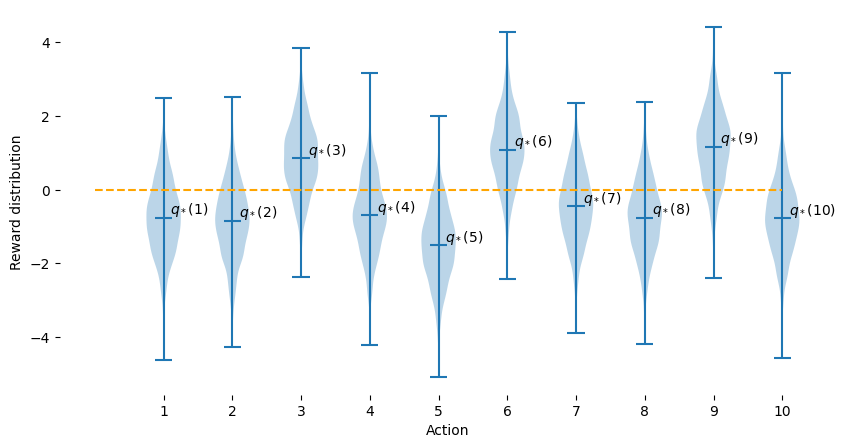

In [4]:
chapter02.figure_2_1(k=10,num=2000,seed=3467)

基于采样平均方法公式（1），就一个动作而言，令$R_i$表示这一动作被选择$i$次后获得的收益，$Q_n$表示被选择$n-1$次后估计的动作价值，简写为$Q_n \doteq \frac{R_1+R_2+\cdots+R_{n-1}}{n-1}$。上述公式计算时需要维护所有收益的记录， 以便在估计动作价值时进行计算，这无疑增加了内存使用量和计算成本，因此设计增量式公式（incremental formulas）以小而恒定的计算来更新动作价值的平均值，其推演过程如下，

$$
\begin{aligned}
Q_{n+1} & =\frac{1}{n} \sum_{i=1}^n R_i \\
& =\frac{1}{n}\left(R_n+\sum_{i=1}^{n-1} R_i\right) \\
& =\frac{1}{n}\left(R_n+(n-1) \frac{1}{n-1} \sum_{i=1}^{n-1} R_i\right) \\
& =\frac{1}{n}\left(R_n+(n-1) Q_n\right) \\
& =\frac{1}{n}\left(R_n+n Q_n-Q_n\right) \\
& =Q_n+\frac{1}{n}\left[R_n-Q_n\right], (2)
\end{aligned}
$$

公式（2）对$n=1$同样有效，对任意$Q_1$有$Q_2=R_1$。对于每一新的动作收益，公式（2）计算方法只需要存储$Q_n$和$n$，其一般的形式可写为$\text { NewEstimate } \leftarrow \text { OldEstimate }+ \text { StepSize }[\text { Target }- \text { OldEstimate }] ,(3)$（$新估计值 \leftarrow 旧估计值 + 步长 \times [目标 - 旧估计值]$），式中，$[目标 - 旧估计值]$是估计值的误差，误差会随着向目标（target）靠近的每一步而减小。公式（2）中的目标为第$n$次的收益，步长（stepsize）记作$n$，更一般的步长表示为$\alpha$或者$\alpha_t(a)$。

多臂赌博机算法的伪代码可以写为：

```algorithm
% WGAN
\begin{algorithm}
\caption{A simple bandit algorithm}
\begin{algorithmic}
\FOR{$a = 1$ to $k$(\textbf{Initialize})}
\STATE  $Q(a) \leftarrow 0$
\STATE $N(a) \leftarrow 0$
\ENDFOR
\WHILE{(\textbf{Loop forever})}
\STATE $A \leftarrow \begin{cases}\operatorname{argmax}_a Q(a) & \text { with probability } 1-\varepsilon \quad \text { (breaking ties randomly) } \\ \text { a random action } & \text { with probability } \varepsilon\end{cases} $
\STATE $R \leftarrow \operatorname{bandit}(A)$
\STATE $N(A) \leftarrow N(A)+1$
\STATE $Q(A) \leftarrow Q(A)+\frac{1}{N(A)}[R-Q(A)]$
\ENDWHILE
\end{algorithmic}
\end{algorithm}
```

对应到 Shangtong Zhang 书写的代码为：

In [6]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward


def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

其中，动作价值估计$Q(a)$（$Q(A)$）对应变量`q_estimation`；不同动作计数$N(a)$（$N(A)$）对应变量`action_count`；开发/试探权衡中，动作选择$A$对应语句为（`act()`方法）：

```python
if np.random.rand() < self.epsilon:
    return np.random.choice(self.indices)
...
q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])    
```

$t$时刻所选动作$A$的收益（奖励）$R$对应语句`reward = np.random.randn() + self.q_true[action]`；计算动作价值（$Q(A)$）时，使用采样平均方法的增量式实现（`sample_averages=True`），对应语句`self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]`。

下述使用迁移至`USDA`库的代码实现下述计算（或从 [Shangtong Zhang 代码实现仓库](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)<sup>①</sup>下载执行），比较开发/试探权衡，配置不同的$\epsilon$，值为0时，为完全“开发”模式，无“试探”过程；值为0.1时和0.01时，考虑了以较小几率加入”试探“的过程，0.1的值相对0.01具有更多”试探“的机会。配置执行迭代次数为2000次，每一次迭代选择拉动老虎机控制杆的次数（一个时刻选择一台拉动）为1000次，每一新一轮迭代都需要调用`reset()`方法随机重置每个老虎机的奖励$q_*(a)$（动作的真实价值）`q_true`；$t$时刻动作的价值估计$Q_t(a)$，`q_estimation`；已执行的动作计数$N(A)$（已拉动每台老虎机控制杆次数），`action_count`；及具有最大价值的动作`best_action`，并从头执行1000次动作配置`time=0`。

In [7]:
runs=2000
time=1000
epsilons = [0, 0.1, 0.01]

bandits = [chapter02.Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:02<00:00, 31.88it/s]


下述左侧图显示了期望的收益随着经验（不断拉动老虎机控制杆至1000次）的增长而增长，尤其在开始阶段3种配置开发/试探权衡的$\epsilon$参数试验结果值均快速的爬升；并可以观察到从长远来看加入“试探”的权衡策略表现的更好；且当$\epsilon=0.1$时，具有相对更高期望的收益。这一现象也表现在随着经验的增加，动作的价值随之不断提升的过程。虽然$\epsilon=0.01$时，期望收益和动作价值改善的比较慢，但是从更长远的情况来看，最终性能的表现要好于$\epsilon=0.1$时的权衡状态。

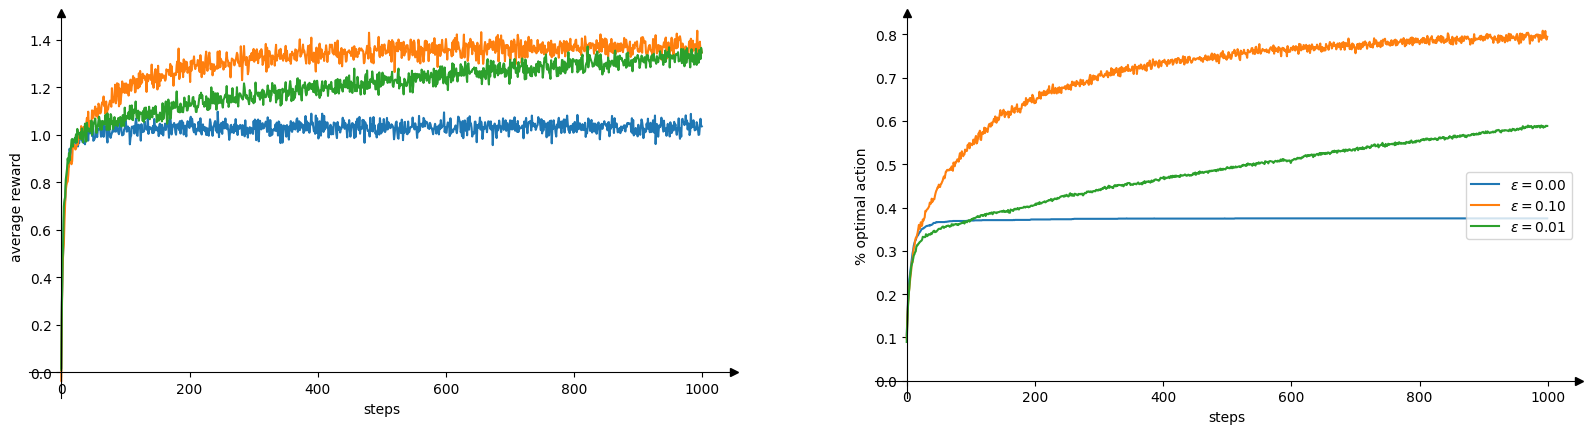

In [11]:
chapter02.figure_2_2(best_action_counts, rewards,epsilons,figsize=(20, 5))

下面打印了$\epsilon=0.1$，在`time=1000`次时期望收益`q_true`、动作价值`q_estimation`、动作计数`action_count`等状态值。

In [114]:
bandit=bandits[1]
print(f'time:\t{bandit.time};\
    \nq_true:\t{np.around(bandit.q_true,3)};\
    \nq_estimation:\t{np.around(bandit.q_estimation,3)};\
    \naction_count:\t{bandit.action_count};\
    \nbest_action:\t{bandit.best_action};\
    \naverage_reward:\t{np.around(bandit.average_reward,3)};')

time:	1000;    
q_true:	[-1.055 -1.079  2.074 -0.71  -0.672 -1.416 -0.564  0.407 -0.659  0.057];    
q_estimation:	[-0.924 -0.749  2.117 -0.444 -0.6   -1.369 -0.625  0.338 -0.879 -0.01 ];    
action_count:	[ 11.   9. 846.   8.  15.  11.  14.  69.   7.  10.];    
best_action:	2;    
average_reward:	1.755;


### 3.9.1.2 （指数近因）加权平均（exponential recency-weighted average）和乐观初始值（Optimistic Initial Values）

使用采样平均方法估计动作价值，适用于收益的概率分布不随时间变化的赌博机问题，但是对于非平稳的强化学习问题，给近期的收益赋予比过去很久的收益更高的权值是一种合理的处理方式，将公式（2）用于更新$n-1$个过去收益的均值$Q_n$的增量更新规则调整为$Q_{n+1} \doteq Q_n+\alpha\left[R_n-Q_n\right]$，式中，步长参数$\alpha \in (0,1]$是一个常数，推导有

$$
\begin{aligned}
Q_{n+1}= & Q_n+\alpha\left[R_n-Q_n\right] \\
= & \alpha R_n+(1-\alpha) Q_n \\
= & \alpha R_n+(1-\alpha)\left[\alpha R_{n-1}+(1-\alpha) Q_{n-1}\right] \\
= & \alpha R_n+(1-\alpha) \alpha R_{n-1}+(1-\alpha)^2 Q_{n-1} \\
= & \alpha R_n+(1-\alpha) \alpha R_{n-1}+(1-\alpha)^2 \alpha R_{n-2}+  \cdots+(1-\alpha)^{n-1} \alpha R_1+(1-\alpha)^n Q_1 \\
= & (1-\alpha)^n Q_1+\sum_{i=1}^n \alpha(1-\alpha)^{n-i} R_i 
\end{aligned}
$$

使得$Q_{n+1}$成为对过去的收益和初始的估计$Q_1$的加权平均，可以验证$(1-a)^n+\sum_{i=1}^n \alpha(1-\alpha)^{n-i}=1$。赋予收益$R_i$的权值$\alpha(1-\alpha)^{n-i}$依赖于它被观测到的具体时刻与当前时刻的差，即$n-i$。因为$1-\alpha$小于1，因此赋予$R_i$的权值随着相隔次数的增加而递减（以指数形式递减），因此也称为指数近因加权平均。

上述试验初始化动作价值$Q_1(a)$时为0，为动作收益真实值的均值（因为采样于均值为0和方差为1的标准正态分布）。如果初始化动作价值为 +5 ，从前文打印的10个老虎机收益分布的小提琴图 (ViolinPlot)可以得知，+5 是一个非常乐观的初始化值。从下述打印的比较结果可以观察到，在平稳问题上，乐观初始动作价值是有效的，虽然开始迭代阶段波动较大，因为需要更多的“试探”而表现糟糕，但是随着时间的推移，最终获得了较高且平稳的动作的价值。但需要注意，任何仅仅关注初始条件的方法都不太可能对一般的非平稳情况有帮助（开始时刻仅出现一次，因此不应该过多的关注）。

In [12]:
runs=2000
time=1000

bandits = []
bandits.append(chapter02.Bandit(epsilon=0, initial=5, step_size=0.1))
bandits.append(chapter02.Bandit(epsilon=0.1, initial=0, step_size=0.1))
best_action_counts, _ = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:04<00:00, 30.91it/s]


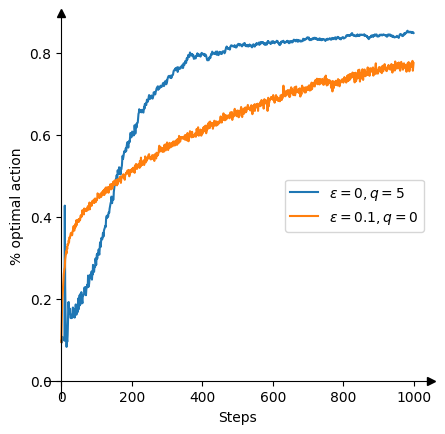

In [13]:
chapter02.figure_2_3(best_action_counts)

### 3.9.1.3 基于置信度上界（ Upper-Conﬁdence-Bound，UCB）的动作选择

动作-价值估计总是存在不确定性，但是上述试验在估计了动作价值后，开发/试探权衡中的“开发”总是选择具有最大估计价值的动作，因此最好是根据各个动作的潜力来选择可能事实上最优的动作，从而需要考虑各自的价值估计有多接近最大值，及其估计的不确定性，调整“开发”的动作选择公式，有$A_t \doteq \underset{a}{\arg \max }\left[Q_t(a)+c \sqrt{\frac{\ln t}{N_t(a)}}\right]$，式中，$\ln t$表示时刻$t$的自然对数（即$e  \approx  2.71828 $的多少次方等于$t$）；$N_t(a)$表示在时刻$t$之前动作$a$被选择的次数；$c$是一个大于0的常数，控制变化幅度，决定了置信水平。如果$N_t(a)=0$，则认为$a$是满足最大化条件的动作。

基于 UCB 选择的思想是平方根项是对动作$a$价值估计的不确定性或方差的度量。由于$N_t(a)$出现在不确定项的分母上，因此随着$N_t(a)$的增加，该项减小，不确定性可能会减小；如果$N_t(a)$没有变化，而随着时刻$t$的增加，不确定性则可能会增加。自然对数的使用意味着随着时间的推移，增加会变得越来越小，但它是无限的。所有动作都会被选中，但是随着时间的流逝，具有较低价值估计的动作或已经被选择了更多次的动作被选择到的频率较低。

UCB 代码实现为， 

```python
if self.UCB_param is not None:
    UCB_estimation = self.q_estimation + self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))        
    q_best = np.max(UCB_estimation)
    return np.random.choice(np.where(UCB_estimation == q_best)[0])
```

下述试验结果也验证了 UCB 算法的可行性，相较$\epsilon=0.1$的平均收益曲线，UCB 方法相对收敛到更高的平均收益水平上。

In [14]:
runs=2000
time=1000

bandits = []
bandits.append(chapter02.Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(chapter02.Bandit(epsilon=0.1, sample_averages=True))
_, average_rewards = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:00<00:00, 32.82it/s]


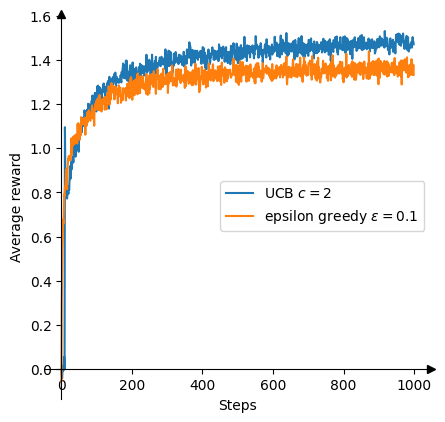

In [16]:
chapter02.figure_2_4(average_rewards)  

### 3.9.1.4 梯度（Gradient）赌博机算法

针对每个动作$a$，考虑学习一个数值偏好（numerical preference）$N_t(a)$，偏好越大，对应的动作被选择的几率就越大，依据 softmax 分布（吉布斯（Gibbs）或玻尔兹曼（Boltzmann）分布）确定动作概率，$\operatorname{Pr}\left\{A_t=a\right\} \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}} \doteq \pi_t(a)$，式中，$\pi_t(a)$表示动作$a$在时刻$t$被选择的概率。对应的代码实现为，


```python
if self.gradient:
    exp_est = np.exp(self.q_estimation)
    self.action_prob = exp_est / np.sum(exp_est)
    return np.random.choice(self.indices, p=self.action_prob)
```


基于随机梯度上升（stochastic gradient ascent）的思想，存在一种求解 soft-max 动作偏好（soft-max action preferences）的自然学习算法，每一时刻$t$，在选择动作$A_t$并获得收益$R_t$后，动作偏好（动作价值估计）更新为$
H_{t+1}\left(A_t\right) \doteq H_t\left(A_t\right)+\alpha\left(R_t-\bar{R}_t\right)\left(1-\pi_t\left(A_t\right)\right), \quad \text { and } \\  H_{t+1}(a) \doteq H_t(a)-\alpha\left(R_t-\bar{R}_t\right) \pi_t(a), \quad \text { for all } a \neq A_t$，式中，$\alpha$是一个大于0的数，表示步长；$\bar{R}_t \in \mathbb{R}$是在时刻$t$内所有收益的平均值，作为比较收益的一个基准项。如果收益高于基准项，那么在未来选择动作$A_t$的概率就会增加，反之概率就会降低，而未选择的动作被选中的概率上升。对应的代码实现为，


```python
elif self.gradient:
    one_hot = np.zeros(self.k)
    one_hot[action] = 1
    if self.gradient_baseline:
        baseline = self.average_reward
    else:
        baseline = 0
    self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
```

下述试验梯度赌博机算法，配置真实的期望收益为 +4，在给定收益基准项（reward baseline term）（即平均收益）时，所有动作的价值估计可以马上适应到新的收益水平；如果没有基准项（$\bar{R}_t =0$），性能显著降低。

In [17]:
runs=2000
time=1000

bandits = []
bandits.append(chapter02.Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(chapter02.Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(chapter02.Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(chapter02.Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = chapter02.simulate(runs, time, bandits)

100%|█████████████████████████████████████████████| 2000/2000 [01:58<00:00, 16.85it/s]


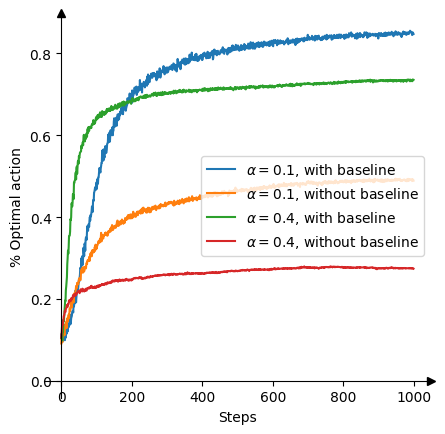

In [19]:
chapter02.figure_2_5(best_action_counts,bandits)

## 3.9.2 有限马尔可夫决策过程与动态规划

### 3.9.2.1 强化学习要素

#### 1) 智能体-环境交互接口（Agent–Environment Interface）

马尔可夫决策过程（Markov Decision Processes，MDP）是一种通过交互式学习实现目标的理论框架。进行学习及实施决策的机器被称为智能体（agent）。智能体之外所有与其相互作用的事物都被称为环境（environment）。这些事物之间持续进行交互，智能体选择动作，环境对这些动作做出相应的响应，并向智能体呈现出新的状态。环境也会产生一个收益，通常是特定的数值，这就是智能体在动作选择的过程中想要最大化的目标，如图<sup>[2]48</sup>，

<img src="../imgs/3_9/3_9_02.png" height='auto' width=500 title="caDesign"> 

更具体的说，在每个离散时刻$t=0,1,2,3, \ldots$，智能体和环境都发生了交互。在每个时刻$t$，智能体观察到所在环境状态的某种特征表达，$S_t \in \mathcal{S} $，并且在此基础上选择一个动作，$A_t \in \mathcal{A}(s)$。下一时刻，作为其动作的结果，智能体接收到一个数值化的收益（reward），$R_{t+1} \in \mathcal{R} \subset \mathbb{R}$，并进入到一个新的状态$\mathcal{S_{t+1}}$。从而，MDP 和智能体共同给出了一个序列或轨迹（trajectory），如$S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, \ldots$。

在有限 MDP 中，状态、动作和收益的集合（$\mathcal{S}、\mathcal{A}$和$\mathcal{R}$）都只有有限个元素，随机变量$\mathcal{R_t}$和$\mathcal{S_t}$具有定义明确的离散概率分布，并且只依赖于先前的状态和动作，即给定先前的状态和动作时，这些随机变量的特定值，$s^{\prime} \in \mathcal{S}$和$r \in \mathcal{R}$，在$t$时刻出现的概率是$p\left(s^{\prime}, r \mid s, a\right) \doteq \operatorname{Pr}\left\{S_t=s^{\prime}, R_t=r \mid S_{t-1}=s, A_{t-1}=a\right\}, (1)$，对于任意$s^{\prime}$，$s \in \mathcal{S}$，$r \in \mathcal{R}$，及$a \in \mathcal{A_s}$。函数$p$定义了 MDP 的动态特性。上述公式是一个定义，为函数$p$。动态函数$p: \mathcal{S} \times \mathcal{R} \times \mathcal{S} \times \mathcal{A} \rightarrow[0,1] $是有4个参数的普通确定性函数（deterministic function）。公式（1）中的"|"为条件概率符号，表示函数$p$为每个$s$和$a$的选择都指定了一个概率分布，即$\sum_{s^{\prime} \in \mathcal{S}} \sum_{r \in \mathcal{R}} p\left(s^{\prime}, r \mid s, a\right)=1 \text {, for all } s \in \mathcal{S}, a \in \mathcal{A}(s)$。

对于 MDP，由$p$给出的概率完全刻画了环境的动态特征，$S_t$和$R_t$的每个可能的值出现的概率只取决于前一个状态$S_{t-1}$和前一个动作$A_{t-1}$，且与更早之前的状态和动作完全无关。这个限制并不是针对决策过程，而是状态。状态必须包括过去智能体和环境交互的方方面面的信息，这些信息会对未来产生一定影响。这样，状态就被认为具有马尔可夫性。从四参数动态函数$p$中，可以计算出关于环境的任何其它信息，例如状态转移概率（表示为一个三参数函数$p: S \times S \times \mathcal{A} \rightarrow[0,1])$）：$ p\left(s^{\prime} \mid s, a\right) \doteq \operatorname{Pr}\left\{S_t=s^{\prime} \mid S_{t-1}=s, A_{t-1}=a\right\}=\sum_{r \in \mathcal{R}} p\left(s^{\prime}, r \mid s, a\right) $；如果定义“状态-动作”二元组的期望收益，将其表示为一个双参数函数$r: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$：$r(s, a) \doteq \mathbb{E}\left[R_t \mid S_{t-1}=s, A_{t-1}=a\right]=\sum_{r \in \mathcal{R}} r \sum_{s^{\prime} \in \mathcal{S}} p\left(s^{\prime}, r \mid s, a\right)$；和“状态-动作-后继状态”三元组的期望收益，表示为一个三参数函数$r: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \rightarrow \mathbb{R}$：$r\left(s, a, s^{\prime}\right) \doteq \mathbb{E}\left[R_t \mid S_{t-1}=s, A_{t-1}=a, S_t=s^{\prime}\right]=\sum_{r \in \mathcal{R}} r \frac{p\left(s^{\prime}, r \mid s, a\right)}{p\left(s^{\prime} \mid s, a\right)}$。

#### 2）目标和收益

在强化学习中，智能体的目标被形式化表征为一种特殊信号，称为收益（rewards），它通过环境传递给智能体。在每个时刻，收益都是一个单一标量数值，$R_t \in  \mathbb{R}$。通俗来说，智能体的目标是最大化其收到的总收益，这意味着需要最大化的不是当前收益，而是长期的累积收益。即所有的目标（goals）都可以归结为：最大化智能体接收到的标量信号（收益）累积和的概率期望值。收益信号并不是传授智能体如何实现目标的先验知识，只能用来传达要实现的目标是什么。

#### 3）回报和分幕

智能体的目标是最大限度的提高长期收益，如果把时刻$t$后接收到的收益序列表示为$R_{t+1}, R_{t+2}, R_{t+3}, \ldots$，将寻求其最大化期望回报（expected return）记为$G_t$，定义为收益序列的一些特定函数。最简单情况是求收益的总和$G_t \doteq R_{t+1}+R_{t+2}+R_{t+3}+\cdots+R_T,(2)$，式中，$T$是最终时刻。这种方法在有“最终时刻”这种概念的应用中是有意义的。在这类应用中，智能体和环境的交互被自然的分成一系列子序列（每个序列都存在最终时刻），称每个子序列为幕（episodes）。例如，一盘游戏、一次走迷宫的旅程或任何这类重复性的交互过程。每幕都以一种特殊状态结束，称之为终结状态（terminal state）。随后会重新从某个标准的起始状态或起始状态分布中的某个状态样本开始。即使结束方式不同，下一幕的开始状态与上一幕的结束方式完全无关。因此，这些幕可以被认为在同样的终结状态下结束，只是对不同的结果有不同的收益。具有这种分幕重复特性的任务称为分幕式任务（episodic tasks）。在分幕任务中，有时需要区分非终结状态集，记为$S$，和包含终结和非终结状态的所有状态集，记作$S^+$。终结的时间$T$是一个随机变量，通常随着幕的不同而不同。

另一方面，诸如长期运行机器人的应用，其智能体-环境交互不一定能被自然的分成单独的幕，而是持续不断的发生，将其称之为持续性任务（continuing tasks）。因为最终时刻$T=\infty$，试图最大化的回报往往也趋于无穷，因此引入折扣（discounting）。智能体尝试选择动作时，使得它在未来收到的经过折扣系数加权后的收益（discounted rewards）总和最大化，选择动作$A_t$来最大化期望折后回报，$G_t \doteq R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3}+\cdots=\sum_{k=0}^{\infty} \gamma^k R_{t+k+1},(3)$，式中，$\gamma$是一个参数，$0 \leq \gamma \leq 1$，称为折扣率（discount rate）。

折扣率决定了未来收益的现值（present value），未来时刻$k$的收益只有它当前值的$\gamma^{k-1}$倍。如果$\gamma<1$，那么只要收益序列$\left\{R_k\right\} $有界，公式（3）中的无限序列总和就是一个有限值。如果$\gamma=0$，则为$ G_t \doteq R_{t+1}$，其目标只是学习如何选择$A_t$来最大化$R_{t+1}$，即只关心最大化当前收益。随着$\gamma$接近1，折后回报将同时考虑更多未来的收益。

连续时间步的回报彼此相关，有$ G_t \doteq R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3}+\gamma^3 R_{t+4}+\cdots \\ =R_{t+1}+\gamma\left(R_{t+2}+\gamma R_{t+3}+\gamma^2 R_{t+4}+\cdots\right) \\ =R_{t+1}+\gamma G_{t+1}$，(4)。如果定义$G_T=0$，公式（4）会适用任意$t<T$时刻，即使最终时刻出现在$t+1$也不例外。尽管公式（4）中定义的回报是对无限个收益子项求和，但只要收益是一个非零常数且$\gamma<1$，那这个回报仍旧是有限的。例如，如果收益是一个常数+1，那么回报为$G_t=\sum_{k=0}^{\infty} \gamma^k=\frac{1}{1-\gamma}$。

对于分幕式任务，通常使用$S_{t,i}$来表示幕$i$中$t$时刻的状态，同样有$R_{t,i}$、$\pi_{t,i}$和$T_i$等。然而实际上在讨论分幕式任务时，不必区分不同的幕，而直接用$S_t$表示$S_{t,i}$。因此对于分幕式任务和持续性任务也可以使用一种统一的符号表述，同样包括将回报定义为有限项的总和（式（2））和无限项的总和（式（3）），如下述状态转移图<sup>[2]57</sup>，

<img src="../imgs/3_9/3_9_03.png" height='auto' width=500 title="caDesign"> 

图中灰色填充方块表示把幕的终止当作一个特殊的吸收状态（absorbing state）的入口。从$S_0$开始，就会得到一个收益序列$+1,+1,+1,0,0,0, \ldots$，可以看到，不管是计算有限个时刻的收益（$T=3$），还是无限序列的全部收益总和，都得到相同的回报。因此也可以将回报表示为$G_t \doteq \sum_{k=t+1}^T \gamma^{k-t-1} R_k$，允许公式包括$T=\infty$和$\gamma=1$(二者不同时)的可能性。

#### 4）策略和价值函数

价值函数（Value Functions）是状态（states）或状态-动作二元组（state–action pairs）的函数，用来评估当前智能体在给定状态或状态-动作下未来预期的收益有多好，即回报的期望值。智能体期望未来能得到的收益取决于智能体所选择的动作，因此，价值函数与特定行为方式相关，称之为策略（policies），即从状态到每个动作的选择概率之间的映射。如果智能体在时刻$t$选择了策略$\pi$，那么$\pi(a \mid s)$就是当$S_t=s$时$A_t=a$的概率。同$p$一样，$\pi$就是一个普通的函数，其中“$\mid$”可理解为每个$s \in \mathcal{S}$都定义了一个在$a \in \mathcal{A}$上的概率分布。

将策略$\pi$下状态$s$的价值函数记为$v_\pi(s)$，即从状态$s$开始，智能体按照策略$\pi$进行决策所获得回报的概率期望值。对于 MDP 可以正式定义为，$v_\pi(s) \doteq \mathbb{E}_\pi\left[G_t \mid S_t=s\right]=\mathbb{E}_\pi\left[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \mid S_t=s\right]$, for all $s \in \mathcal{S}，(5)$，式中，$\mathbb{E}_\pi[\cdot]$表示在给定策略$\pi$时，一个随机变量的期望值，$t$可以是任意时刻，且终止状态的价值始终为0。将函数$v_\pi$称为策略$\pi$的状态价值函数。

类似的，策略$\pi$下，在状态$s$时采取动作$a$的价值记为$q_\pi(s, a)$，是根据策略$\pi$，从状态$s$开始，执行动作$a$之后，所有可能决策序列的期望回报，$q_\pi(s, a) \doteq \mathbb{E}_\pi\left[G_t \mid S_t=s, A_t=a\right]=\mathbb{E}_\pi\left[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \mid S_t=s, A_t=a\right]，(6)$。将函数$q_\pi$称为策略$\pi$的动作价值函数。

状态和动作的价值函数$v_\pi$和$q_\pi$都能从经验中估算得到。例如，一个智能体遵循策略$\pi$，并且对每个遇到的状态都记录该状态后实际回报的平均值，那么，随着状态出现次数接近无穷大，其均值会收敛到状态价值$v_\pi(s)$；同样，如果每个状态的每个动作都保留单独的平均值，这些均值也会收敛到动作价值$q_\pi(s,a)$，这种估算方法称为蒙特卡洛方法（Monte Carlo methods），涉及从真实回报的多个随机样本中求平均值。当环境中有很多状态时，独立估算每个状态的平均值往往不切实际，因此可以将价值函数$v_\pi$和$q_\pi$进行参数化，参数的数量远少于状态的数量，然后通过调整价值函数的参数更好的计算回报值。

同连续时间步的回报彼此相关的公式（4），价值函数也可以建立为一个递归公式，对于任何策略$\pi$和任何状态$s$，$s$的价值与其可能的后继状态价值之间存在的关系为，


$$
\begin{aligned}
v_\pi(s) & \doteq \mathbb{E}_\pi\left[G_t \mid S_t=s\right] \\
& =\mathbb{E}_\pi\left[R_{t+1}+\gamma G_{t+1} \mid S_t=s\right] \\
& =\sum_a \pi(a \mid s) \sum_{s^{\prime}} \sum_r p\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma \mathbb{E}_\pi\left[G_{t+1} \mid S_{t+1}=s^{\prime}\right]\right] \\
& =\sum_a \pi(a \mid s) \sum_{s^{\prime}, r} p\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma v_\pi\left(s^{\prime}\right)\right], \quad \text { for all } s \in \mathcal{S} ，（7）
\end{aligned}
$$，

式（7）被称为$v_\pi$的贝尔曼方程（Bellman equation），用等式表达了状态价值和后继状态价值之间的关系。

以回溯图（Backup diagram）的方式表述状态之间的关系（从一个状态向后观察所有可能到达的后继状态），如图<sup>[2]59</sup>，

<img src="../imgs/3_9/3_9_04.png" height='auto' width=300 title="caDesign"> 

图中，空心圆表示一个状态，实心圆表示一个“状态-动作”二元组。将状态$s$作为根节点，智能体可以根据其策略$\pi$，采取动作集合中的任意一个动作（图中给出了3个动作）。对于每一个动作，环境会根据其动态特性函数$p$，以一个后继状态$s^\prime$（图中给出了两个状态）及其收益$r$作为响应。贝尔曼方程（7）随所有的可能性求均值，按其发生的概率对每种可能性进行加权。回溯操作就是将后继状态（或状态-动作二元组）的价值信息回传给当前时刻的状态（或状态-动作二元组）。

#### 5）最优策略和最优价值函数

强化学习的任务是要找出一个策略，使其能够在长期过程中获得最大收益。对于有限 MDP，可以通过比较价值函数精确定义一个最优策略。本质上，价值函数定义了策略上的一个偏序关系，即如果策略$\pi$相当或好于策略$\pi^\prime$，那么$\pi$上所有状态上的期望回报都应该等于或者大于$\pi^\prime$。用公式表述为，若对于所有的$s \in \mathcal{S}$，则有$v_\pi(s) \geq v_{\pi^{\prime}}(s)$。总会存在至少一个策略不略于其它所有的策略，即为最优策略（optimal policy）。尽管最优策略可能不止一个，但通常用$\pi_*$来表示。最优策略$\pi_*$共享相同的状态价值函数，称之为最优状态价值函数（optimal state-value function），定义为，$v_*(s) \doteq \max _\pi v_\pi(s)$, for all $s \in \mathcal{S}$；最优策略也共享相同的动作价值函数，称之为最优动作价值函数（optimal action-value function），定义为，$q_*(s, a) \doteq \max _\pi q_\pi(s, a)$, for all $s \in \mathcal{S}$ and $a \in \mathcal{A}(s)$。对于“状态-动作”二元组$(s,a)$，给出了在状态$s$下，先采取动作$a$，之后按照最优策略去决策的期望回报。因此可以用$v_*$来表示$q_*$，有，$q_*(s, a)=\mathbb{E}\left[R_{t+1}+\gamma v_*\left(S_{t+1}\right) \mid S_t=s, A_t=a\right]$。

最优状态价值函数的贝尔曼最优方程推导为，

$$
\begin{aligned}
v_*(s) & =\max _{a \in \mathcal{A}(s)} q_{\pi_*}(s, a) \\
& =\max _a \mathbb{E}_{\pi_*}\left[G_t \mid S_t=s, A_t=a\right] \\
& =\max _a \mathbb{E}_{\pi_*}\left[R_{t+1}+\gamma G_{t+1} \mid S_t=s, A_t=a\right] \\
& =\max _a \mathbb{E}\left[R_{t+1}+\gamma v_*\left(S_{t+1}\right) \mid S_t=s, A_t=a\right] ， （8）\\
& =\max _a \sum_{s^{\prime}, r} p\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma v_*\left(s^{\prime}\right)\right]， （9）
\end{aligned}
$$

公式（8）和（9）就是$v_*$的贝尔曼最优方程的两种形式。贝尔曼最优方程阐述了，最优策略下各个状态的价值一定等于这个状态下最优动作的期望回报。同样，$q_*$的贝尔曼最优方程为，

$$
\begin{aligned}
q_*(s, a) & =\mathbb{E}\left[R_{t+1}+\gamma \max _{a^{\prime}} q_*\left(S_{t+1}, a^{\prime}\right) \mid S_t=s, A_t=a\right] \\
& =\sum_{s^{\prime}, r} p\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma \max _{a^{\prime}} q_*\left(s^{\prime}, a^{\prime}\right)\right]，（10）
\end{aligned}
$$

最优状态价值函数（$v_*$）和最优动作价值函数（$q_*$）的贝尔曼最优方程中进行的后继状态和动作的扩展过程如图<sup>[2]64</sup>，

<img src="../imgs/3_9/3_9_05.png" height='auto' width=500 title="caDesign"> 

图中在智能体的选择节点处加入了弧线表示应该在给定策略下取最大值而不是期望值。

对于有限 MDP 来说，$v_\pi$的贝尔曼最优方程有独立于策略的唯一解。贝尔曼最优方程实际上是一个方程组，每个状态对应一个方程等式。如果有$n$个状态，那么将有$n$个含有$n$个未知量的方程。如果环境的动态变化特征$p$是已知的，那么原则上可以用解非线性方程组的方法求解$v_*$方程组。类似的求解$q_*$的一组解。有了$v_*$，就可以确定一个最优策略。对于每个状态$s$，都存在一个或多个动作，可以在贝尔曼最优方程的条件下产生最大的价值。如果在一个策略中，只有这些动作的概率非零，那么这个策略就是一个最优策略。定义$v_*$的意义在于，可以将最优的长期（全局）回报期望值转化为每个状态对应的一个当前局部量的计算。在给定$q_*$的情况下，对于任意状态$s$，智能体只需找到使得$q_*(s,a)$最大化的动作$a$就可以了。它将最优长期回报的期望值表达为对应每个“状态-动作”二元组的一个当前局部量。因此，将价值函数表达为“状态-动作”二元组的函数而不仅仅是状态的函数后，最优动作的选取就不再需要知道后继状态及其对应的价值，即，不再需要知道任何环境的动态变化特性。

### 3.9.2.2 动态规划与网格问题

动态规划（dynamic programming，DP）是一类优化方法，在给定一个用马尔可夫决策过程（MDP）描述的完备环境模型情况下，可以计算最优策略。假设环境为有限 MDP，即假设状态集合$\mathcal{S}$、动作集合$\mathcal{A}$和收益集合$\mathcal{R}$是有限的，且整个系统的动态特性（dynamics）由对于任意$s \in \mathcal{S} 、 a \in \mathcal{A}(s) 、 r \in \mathcal{R}$和$s^{\prime} \in \mathcal{S}^{+}$（$s^{\prime}$表示在分幕任务下$\mathcal{S}$加上一个终止状态）的四参数概率分布$p\left(s^{\prime}, r \mid s, a\right)$给出。对于连续状态和动作问题，可以近似的量化为离散集合，再使用有限状态下的 DP 算法。DP 的核心思想是使用价值函数来结构化的组织对最优策略的搜索，如最优状态价值函数的贝尔曼最优方程（公式9）和最优动作价值函数的贝尔曼最优方程（公式10）。

#### 1）策略评估（预测）

对于任意一个策略$\pi$，如何计算其状态价值函数$v_\pi$，在 DP 文献中称为策略评估（policy evaluation），有时也称其为预测问题（prediction problem）。对应到$v_\pi$的贝尔曼方程（公式 7），$\pi(a \mid s)$指的是处于环境状态 $s$ 时，智能体在策略$\pi$下采取动作$a$的概率。期望的下标$\pi$表明期望的计算是以遵循策略$\pi$为条件的。只要$\gamma < 1$或者任何状态在$\pi$下都能保证最后终止，那么$v_\pi$唯一存在。

如果环境的动态特性完全已知，则公式 7 是一个有着 $\mid\mathcal{S}\mid$个未知数$\left(v_\pi(s), s \in \mathcal{S}\right)$及 $\mid\mathcal{S}\mid$个等式的联立线性方程组。理论上这个方程组的解可以直接被解出，但是通常使用迭代方法求解。考虑一个近似的价值函数序列，$v_0, v_1, v_2, \ldots$，从$\mathcal{S}^{+}$映射到$\mathbb{R}$（实数集）。初始的近似值$v_0$可以任意选取（但终止状态值必须为0）。然后下一轮迭代使用$v_\pi$的贝尔曼方程进行更新，对于任意$s \in \mathcal{S}$，有

$$
\begin{aligned}
v_{k+1}(s) & \doteq \mathbb{E}_\pi\left[R_{t+1}+\gamma v_k\left(S_{t+1}\right) \mid S_t=s\right] \\
& =\sum_a \pi(a \mid s) \sum_{s^{\prime}, r} p\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma v_k\left(s^{\prime}\right)\right]
\end{aligned}
$$

显然，$v_k=v_\pi$是这个更新规划的不动点（ﬁxed point），因为$v_\pi$的贝尔曼方程已经保证了这种情况下的等式成立，序列$\left\{v_k\right\}$在$k \rightarrow \infty$时将会收敛到$v_\pi$。这个算法称为迭代策略评估（iterative policy evaluation）。

以网格问题为例，下图网格代表的是一个简单的有限 MDP。网格中的（格子）单元代表的是环境中的状态$S$。每个单元有4个可选的动作$A$：东、南、西和北，每个动作都会使智能体在对应的方向上前进一格。如果采取的动作使智能体跳出了网格，则智能体会在原位置保持不动，且得到一个值为-1的收益（$R$）；如果智能体位于`A`和`B`单元中，则智能体直接跳到`A'`和`B'`中，而不是邻接的单元中，且分别得到+10和+5的收益；其它情况，智能体跳到邻接单元时，其动作的收益均是0。

<img src="../imgs/3_9/3_9_01.jpg" height='auto' width=400 title="caDesign"> 



将上述过程用代码描述如下，定义网格的大小`WORLD_SIZE`为5；$A,B,A^\prime,B^\prime$的位置对应为`A_POS`、`B_POS`和`A_PRIME_POS`、`B_PRIME_POS`等4个变量；折扣率$\gamma$为`DISCOUNT`；四个动作的概率（$p(s^\prime,r \mid s,a)$）相等，为`ACTION_PROB = 0.25`。

In [21]:
%load_ext autoreload 
%autoreload 2
from usda.migrated_project.RL_an_introduction import chapter03

import matplotlib
%matplotlib inline
matplotlib.style.use('default') 

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
WORLD_SIZE = 5
A_POS = [0, 1]
A_PRIME_POS = [4, 1]
B_POS = [0, 3]
B_PRIME_POS = [2, 3]
DISCOUNT = 0.9
ACTION_PROB = 0.25

# left, up, right, down
ACTIONS=chapter03.grid_world.ACTIONS
ACTIONS_FIGS=chapter03.grid_world.ACTIONS_FIGS
print(f'action={ACTIONS};\naction figs:{ACTIONS_FIGS}')

action=[array([ 0, -1]), array([-1,  0]), array([0, 1]), array([1, 0])];
action figs:['←', '↑', '→', '↓']


为了从$v_k$得到下一个近似$v_{k+1}$，迭代策略评估对于每个状态$s$采用相同的操作：根据给定的策略，得到所有可能单步转移之后的即时收益`reward`和$s$的每个后继状态旧的价值函数`value[next_i, next_j]`，利用这二者的期望值更新$s$新的价值函数，对应代码`new_value[i, j] += ACTION_PROB * (reward + DISCOUNT * value[next_i, next_j])`（贝尔曼公式（7）），这种方法称期望更新（expected update）。迭代策略评估的每一轮迭代都更新一次所有状态的价值函数，即一次更新是对整个状态空间的一次遍历，以产生新的近似价值函数$v_{k+1}$。期望更新可以有很多种不同的形式，具体取决于使用状态还是“状态-动作”二元组，或者后继状态价值函数的具体组合方式。

`step()`函数定义了$t$时刻，智能体所在状态$s$（即位于的一个单元格）`state`，执行等概率的动作$a$（`action`）进入下一个状态$s^\prime$（`next_state`），并返回上述定义的收益$r$（`reward`）和下一个状态（单元索引）。

In [18]:
def step(state, action):
    if state == A_POS:
        return A_PRIME_POS, 10
    if state == B_POS:
        return B_PRIME_POS, 5

    next_state = (np.array(state) + action).tolist()
    x, y = next_state
    if x < 0 or x >= WORLD_SIZE or y < 0 or y >= WORLD_SIZE:
        reward = -1.0
        next_state = state
    else:
        reward = 0
    return next_state, reward

计算给定折扣率$\gamma=0.9$，等概率的4种动作策略下的价值函数$v_\pi$如下。当$v_{k+1}$和$v_k$的状态价值函数变化和趋近于0（$le-4$）时，结束循环。

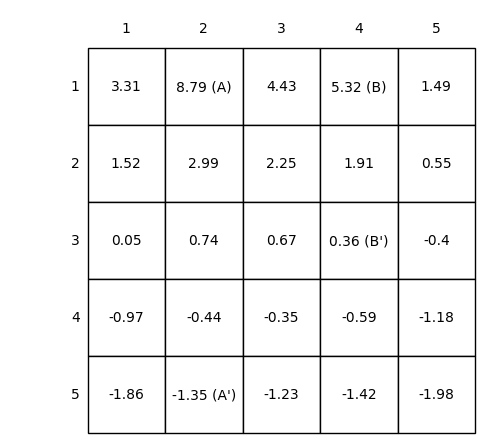

iterations=77


In [3]:
value = np.zeros((WORLD_SIZE, WORLD_SIZE))
k=0
while True:
    # keep iteration until convergence
    new_value = np.zeros_like(value)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            for action in ACTIONS:
                (next_i, next_j), reward = chapter03.step([i, j], action)
                # bellman equation
                new_value[i, j] += ACTION_PROB * (reward + DISCOUNT * value[next_i, next_j])
    k+=1
    if np.sum(np.abs(value - new_value)) < 1e-4:
        chapter03.draw_image(np.round(new_value, decimals=2))
        plt.show()
        break
    value = new_value
print(f'iterations={k}')

除了使用上述的贝尔曼方程通过迭代法求解$v_\pi$，也通过解$\mid\mathcal{S}\mid$个状态的联立线性方程组求精确解，如下过程。

(25, 25),(25,),(25,)


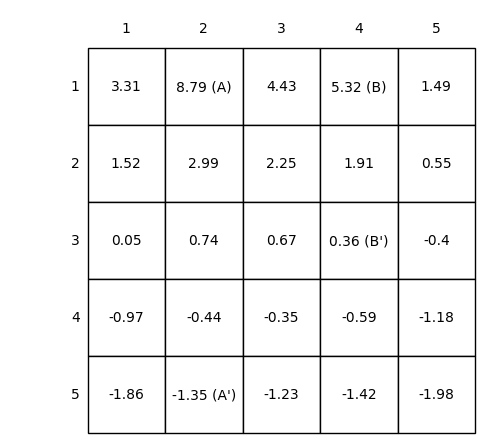

In [23]:
A = -1 * np.eye(WORLD_SIZE * WORLD_SIZE)
b = np.zeros(WORLD_SIZE * WORLD_SIZE)
for i in range(WORLD_SIZE):
    for j in range(WORLD_SIZE):
        s = [i, j]  # current state
        index_s = np.ravel_multi_index(s, (WORLD_SIZE, WORLD_SIZE))
        for a in ACTIONS:
            s_, r = chapter03.step(s, a)
            index_s_ = np.ravel_multi_index(s_, (WORLD_SIZE, WORLD_SIZE))

            A[index_s, index_s_] += ACTION_PROB * DISCOUNT
            b[index_s] -= ACTION_PROB * r

x = np.linalg.solve(A, b)
print(f'{A.shape},{b.shape},{x.shape}')
chapter03.draw_image(np.round(x.reshape(WORLD_SIZE, WORLD_SIZE), decimals=2))

#### 2）策略改进和迭代

计算一个指定策略下的价值函数，是为了寻找更好的策略，如果$\pi$和$\pi^\prime$是任意两个确定的策略，对任意$s \in \mathcal{S}$，$q_\pi\left(s, \pi^{\prime}(s)\right) \geqslant v_\pi(s)$，称策略$\pi^{\prime}$相比于$\pi$一样好或者更好，则肯定能得到一样好或者更好的期望回报$v_{\pi^{\prime}}(s) \geqslant v_\pi(s)$。一旦一个策略$\pi$根据$v_\pi$产生了一个更好的策略$\pi^\prime$，那么通过计算$v_{\pi^\prime}$可以进一步得到一个更优的策略$\pi^{\prime\prime}$。这样一个链式的方法可以得到一个不断改进的策略和价值函数序列$\pi_0 \stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_0} \stackrel{\mathrm{I}}{\longrightarrow} \pi_1 \stackrel{\mathrm{E}}{\longrightarrow} v_{\pi_1} \stackrel{\mathrm{I}}{\longrightarrow} \pi_2 \stackrel{\mathrm{E}}{\longrightarrow} \cdots \stackrel{\mathrm{I}}{\longrightarrow} \pi_* \stackrel{\mathrm{E}}{\longrightarrow} v_*$，式中，$\stackrel{\mathrm{E}}{\longrightarrow}$代表策略评估，$\stackrel{\mathrm{I}}{\longrightarrow}$表示策略改进。每一个策略都能保证比前一个更优（除非前一个已经是最优）。由于有限 MDP 必然只有有限种策略，所以在有限次的迭代后，这种方法一定收敛到一个最优策略和最优价值函数。这种寻找最优策略的方法称为策略迭代（policy iteration）。每一次策略评估都是一个迭代计算的过程，需要基于前一个策略的价值函数开始计算。

策略迭代的伪代码如下：

```algorithm
% WGAN
\begin{algorithm}
\caption{Policy Iteration (using iterative policy evaluation) for estimating }
\begin{algorithmic}
\STATE \textbf{1. Initialization}
\STATE $V(s) \in \mathbb{R}$ and  $\pi(s) \in \mathcal{A}(s)$ arbitrarily for all $s \in \mathcal{S}$; $V(terminal)\doteq 0$
\STATE \textbf{2. Policy Evaluation}
\WHILE{(\textbf{Loop})}
\STATE $\Delta \leftarrow 0$
\FOR{Loop for each $s \in \mathcal{S}$}
\STATE $v \leftarrow V(s)$
\STATE $V(s) \leftarrow \sum_{s^{\prime}, r} p\left(s^{\prime}, r \mid s, \pi(s)\right)\left[r+\gamma V\left(s^{\prime}\right)\right]$
\STATE $\Delta \leftarrow \max (\Delta,|v-V(s)|)$
\ENDFOR 
\STATE until $\Delta<\theta$ (a small positive number determining the accuracy of estimation)
\ENDWHILE 
\STATE \textbf{3. Policy Improvement}
\STATE $policy-stable \leftarrow true$
\FOR{each $s \in \mathcal{S}$}
\STATE $old-action \leftarrow \pi(s)$
\STATE $ \pi(s) \leftarrow \arg \max _a \sum_{s^{\prime}, r} p\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma V\left(s^{\prime}\right)\right]$
\IF{$old-action \neq \pi(s)$}
\STATE $policy-stable \leftarrow false$
\ENDIF
\ENDFOR 
\IF{$policy-stable$}
\STATE stop and return $V \approx v_*$ and $\pi \approx \pi_*$
\ELSE 
\STATE got to 2
\ENDIF
\end{algorithmic}
\end{algorithm}
```

计算最优状态价值函数$v_*$和最优策略$\pi_*$如下，其中

```python
for action in ACTIONS:
    (next_i, next_j), reward = chapter03.step([i, j], action)
    values.append(reward + DISCOUNT * value[next_i, next_j])
new_value[i, j] = np.max(values)
````

对应到贝尔曼最优方程（9）。从最优策略结果可以观察到状态$A,B$的4个方向动作均为最优策略，而其它大部分状态的动作都潜在指向$A,B$状态单元格（其具有最大状态-动作收益）。最优策略图中有些状态有多个箭头，表示有多个动作其价值函数都可以达到最大值。

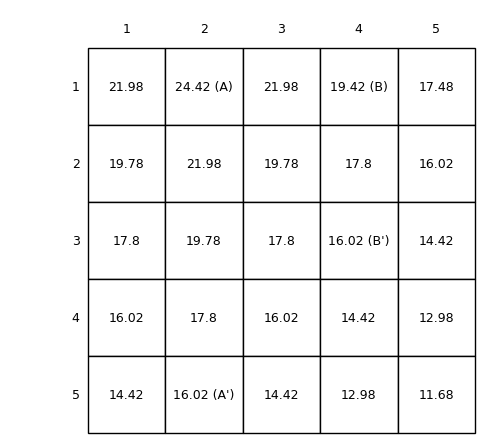

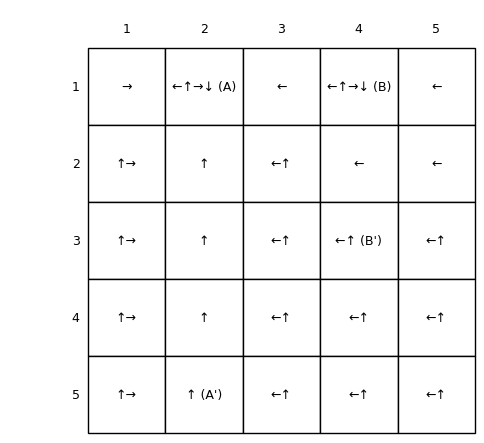

In [12]:
value = np.zeros((WORLD_SIZE, WORLD_SIZE))
while True:
    # keep iteration until convergence
    new_value = np.zeros_like(value)
    for i in range(WORLD_SIZE):
        for j in range(WORLD_SIZE):
            values = []
            for action in ACTIONS:
                (next_i, next_j), reward = chapter03.step([i, j], action)
                # value iteration
                values.append(reward + DISCOUNT * value[next_i, next_j])
            new_value[i, j] = np.max(values)
    if np.sum(np.abs(new_value - value)) < 1e-4:
        chapter03.draw_image(np.round(new_value, decimals=2))
        chapter03.draw_policy(new_value)
        plt.show()
        break
    value = new_value

#### 3）广义策略迭代

策略迭代包括两个同时进行的相互作用的流程，一个使得价值函数与当前策略一致（策略评估）；另一个根据当前价值函数贪心（greedy）的更新策略（策略改进）。在策略迭代中，这两个流程交替进行，也可以在两次策略改进之间执行一次策略评估或者仅有一个状态在评估流程中得到更新后马上返回到改进流程等不同方式，但只要两个流程持续更新所有状态，那么最后的结果通常都收敛到最优价值函数和一个最优策略。将上述策略评估和策略改进相互作用的一般思路称为广义策略迭代（generalized policy iteration，GPI），其流程如下图<sup>[2]86</sup>，策略$\pi$总是基于特定的价值函数$V$进行改进，价值函数也始终向对应特定策略的真实价值函数收敛。如果评估流程和改进流程都很稳定，即不再产生变化，那么价值函数和策略必定是最优的。价值函数只有在与当前策略一致时稳定，且策略只有在对当前价值函数是贪心策略时才稳定。

<img src="../imgs/3_9/3_9_06.png" height='auto' width=180 title="caDesign">

## 3.9.3 蒙特卡洛方法和21点

在*策略和价值函数*部分解释了蒙特卡洛方法（Monte Carlo Methods，MC），通过平均样本的回报来解决强化学习问题。对于分幕式任务，价值估计及策略改进在每个幕结束时进行，因此 MC  为逐幕做出改进，而不是每幕下的每步。类似赌博机算法采样并平均每个动作的收益，MC 采样并平均每个“状态-动作”二元组的回报，该回报取决于同一幕中后来状态采取的动作，从 MDP 采样样本的经验回报中学习价值函数。MC 算法对于每个状态的估计是独立的，即对一个状态的估计完全不依赖于对其它状态的估计；且计算一个状态的价值与状态的个数无关，因此 MC 适合在仅仅需要获得一个或者一个子集的状态的价值函数时使用。可以从这个特定的状态开始采样生成一些幕序列，然后获取回报的平均值，而无需考虑其它的状态。

### 3.9.3.1 MC 预测和同轨策略

21点游戏是手中所有扑克牌点数之和在不超过21点的情况下越大越好。对于点数：所有头牌（J、Q、K）的点数为10；A可以当作1，也可以当作11；其它牌点数同牌自身。对于游戏规则：假设每个玩家（player）都独立的与庄家（dealer）进行比赛。游戏开始时给玩家和庄家各发两张牌。庄家的牌一张正面朝上，一张背面朝上。如果玩家的两张牌一张为 A，一张为10，则为21点（A当作点数11），此种情况玩家直接胜出，称为天和（natural）。如果庄家也为天和，则平局。如果玩家不是天和，则可以一张一张继续叫牌（hits），直到主动停止（停牌）(sticks/stand)或者牌的点数和超过21点（爆牌，goes bust）。如果爆牌则玩家输。如果玩家选择停牌，就轮到庄家行动。庄家根据一个固定的策略进行游戏：庄家一直要牌，直到点数等于或超过17时停牌。如果庄家爆牌则玩家胜出，否则根据谁的点数更靠近21决定胜负或平局。

MC 预测的伪代码如下：

```algorithm
% WGAN
\begin{algorithm}
\caption{First-visit MC prediction, for estimating $V \approx v_\pi$}
\begin{algorithmic}
\STATE \textbf{Input:}  a policy $\pi$ to be evaluated
\STATE \textbf{Initialize:} 
\STATE $V(s) \in \mathbb{R}$, arbitrarily, for all $s \in \mathcal{S}$
\STATE Returns (s) $\leftarrow$ an empty list, for all $s \in \mathcal{S}$
\WHILE{(\textbf{Loop forever},for each episode)}
\STATE Generate an episode following $\pi: S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_{T-1}, A_{T-1}, R_T$
\STATE $G \leftarrow 0$
\FOR{(Loop for each step of episode, $t=T-1, T-2, \ldots, 0$ )}
\STATE  $G \leftarrow \gamma G+R_{t+1}$
\STATE Unless $S_t$ appears in $S_0, S_1, \ldots, S_{t-1}$:
\STATE Append $G$ to Returns $\left(S_t\right)$
\STATE $V\left(S_t\right) \leftarrow \text { average }\left(\operatorname{Returns}\left(S_t\right)\right)$
\ENDFOR 
\ENDWHILE
\end{algorithmic}
\end{algorithm}
```

根据游戏规则书写代码，并假设所有的牌来自无穷多的一组牌（每次取出的牌再放回牌堆中）。动作（$A$）有两个，要（叫）牌（hit）和停牌（stand），对应代码为：

In [23]:
%load_ext autoreload 
%autoreload 2
from usda.migrated_project.RL_an_introduction import chapter05

import matplotlib
%matplotlib inline
matplotlib.style.use('default')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1  #  "strike" in the book
ACTIONS = [ACTION_HIT, ACTION_STAND]
print(ACTIONS)

[0, 1]


在第一个试验中，玩家的策略只在点数和为20或21时停牌；且，如果玩家手上有一张牌A，可以视作11点且不爆牌，则称这张牌A为可用的（usable），此时这张牌总会被视为11，因为如果视作1的化，点数总和必定小于等于11，玩家无需进行动作选择而直接继续叫牌；同理，手中牌点数总和小于等于11时，动作为继续叫牌，因此玩家的策略可写为（手牌点数和0~21对应采取的动作策略）：

In [25]:
# policy for player
POLICY_PLAYER = np.zeros(22, dtype=int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

print(POLICY_PLAYER)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]


庄家的策略假设为直到点数等于或超过17时停牌，因此庄家的策略可写为：

In [26]:
# policy for dealer
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND
print(POLICY_DEALER)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


将每一局看作一幕，收益对应游戏结果的胜、负和平局，得到的收益分别为+1、-1和0。根据21点的游戏规则，模拟一局（一幕）的函数定义为` play(policy_player, initial_state=None, initial_action=None)`（查看`USDA`库的迁移代码或者 Shangtong Zhang 的源码），因为玩家做出选择的动作只会依赖于3个变量，手牌总和（12 ~ 21），庄家显示的牌（A ~ 10），及是否有可用的牌A，因此一幕的返回值包括游戏初始状态`state = [usable_ace_player, player_sum, dealer_card1]`，包括玩家是否将牌 A 视作点数11的变量`usable_ace_player`，手牌点数和`player_sum`和庄家的所显示的牌点数`dealer_card1`。根据这3个变量组合可呈现的状态总共有200（$10*10*2$）个；同时返回一幕的收益；及用于重要度采样而追踪玩家的轨迹（trajectory）`player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])`，包括状态`state`的3个变量和动作`action`。

为了通过 MC 计算上述策略的状态价值函数（`usable_ace_player`、`player_sum`和`dealer_card1`各个组合状态对应的回报/所有幕收益总和的均值），需要根据策略模拟尽可能多的21点游戏。在此次试验中，模拟次数（幕数）包括10,000和500,000次，以便比较不同次数的模拟结果情况。为了智能体可以持续不断的选择所有可能的动作，有两种方法可以保证这一点，分别称为同轨策略（on-policy）和离轨策略（off-policy）方法。在同轨策略中，用于生成采样数据序列的策略和用于实际决策的待评估和改进的策略相同；而在离轨策略中，用于评估或者改进的策略与生成采样数据的策略不同。

在 MC 状态价值函数预测上，使用同轨策略，动作的选择从玩家（庄家）的策略列表中根据手牌点数和对应选择待执行的动作，定义的函数为：

In [28]:
# function form of target policy of player
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):
    states_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_usable_ace_count = np.ones((10, 10))
    states_no_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_no_usable_ace_count = np.ones((10, 10))
    for i in tqdm(range(0, episodes)):
        _, reward, player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12
            dealer_card -= 1
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count

从下述计算结果可以很容易的观察到，有可用牌A的状态的估计会更不确定、不规律，因为这样的状态相对罕见；但随着模拟观测次数的增加，如500,000次后，价值函数（value function）趋近真实价值/期望收益。从图中也可以观察到，不管庄家显示的牌为多少点数和玩家是否有可用的牌A，如果玩家初始的手牌点数总和为20或21时，具有最高的回报，这是显而易见的事实；同时，在有可用牌A时，玩家初始手牌点数和如果在12 ~ 14（15）时，具有比手牌点数在16 ~ 19区间相对高一些的回报。

100%|██████████████████████████████████████| 500000/500000 [00:12<00:00, 40959.10it/s]


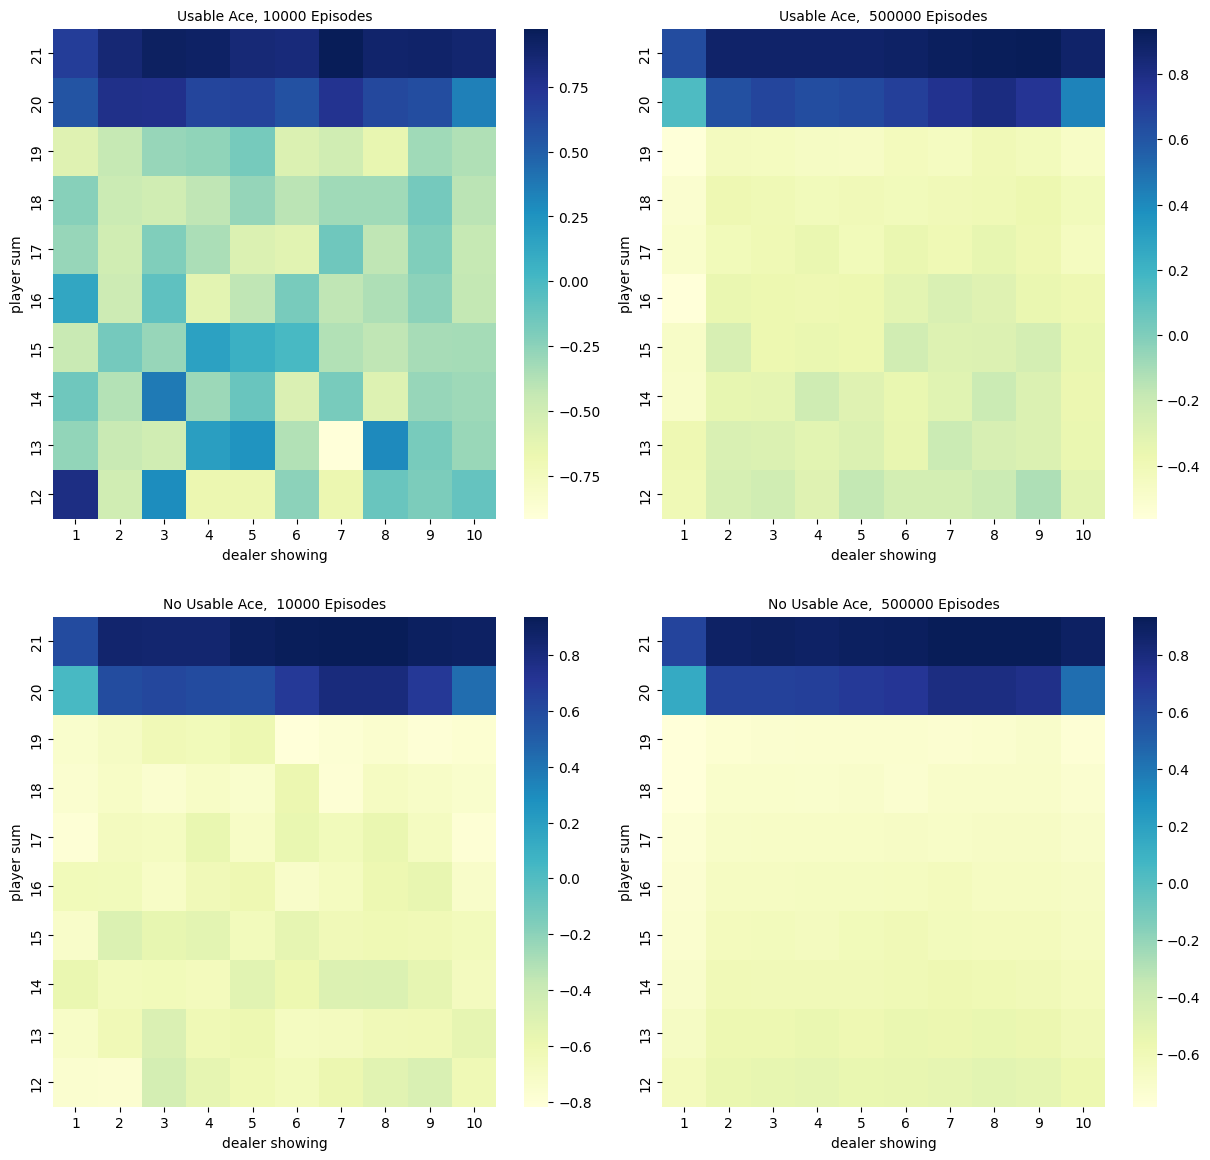

In [29]:
chapter05.figure_5_1()

### 3.9.3.2 基于试探性出发的 MC 

MC 策略迭代可以逐幕交替进行评估与改进。每一幕结束后，使用观测到的回报进行测量评估，然后在该幕序列访问到的每一个状态上进行策略的改进。使用这个思路的一个简单算法称为基于试探性出发的蒙特卡洛（Monte Carlo Exploring Starts，MC ES/Monte Carlo ES），其伪代码如下，

```algorithm
% WGAN
\begin{algorithm}
\caption{Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$}
\begin{algorithmic}
\STATE \textbf{Initialize:} 
\STATE $ \pi(s) \in \mathcal{A}(s) \text { (arbitrarily), for all } s \in \mathcal{S}$
\STATE $ Q(s, a) \in \mathbb{R} \text { (arbitrarily), for all } s \in \mathcal{S}, a \in \mathcal{A}(s)$
\STATE $\text { Returns }(s, a) \leftarrow \text { empty list, for all } s \in \mathcal{S}, a \in \mathcal{A}(s)$
\WHILE{(\textbf{Loop forever},for each episode)}
\STATE Choose $S_0 \in \mathcal{S}, A_0 \in \mathcal{A}\left(S_0\right)$ randomly such that all pairs have probability $>0$ Generate an episode from $S_0, A_0$, following $\pi: S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_T$
\STATE $G \leftarrow 0$
\FOR{(Loop for each step of episode, $t=T-1, T-2, \ldots, 0$ )}
\STATE  $G \leftarrow \gamma G+R_{t+1}$
\STATE Unless the pair $S_t, A_t$ appears in $S_0, A_0, S_1, A_1 \ldots, S_{t-1}, A_{t-1}$:
\STATE Append $G$ to Returns $\left(S_t, A_t\right)$
\STATE $Q\left(S_t, A_t\right) \leftarrow \operatorname{average}\left(\operatorname{Returns}\left(S_t, A_t\right)\right)$
\STATE $\pi\left(S_t\right) \leftarrow \arg \max _a Q\left(S_t, a\right)$
\ENDFOR 
\ENDWHILE
\end{algorithmic}
\end{algorithm}
```

使用MC ES 解决21点问题。对于每一幕随机初始化状态和动作，包括随机等概率的选择庄家的扑克牌、玩家手牌的点数和确定是否有可用的牌A，其对应的代码为：

```python
initial_state = [bool(np.random.choice([0, 1])),
                 np.random.choice(range(12, 22)),
                 np.random.choice(range(1, 11))]
```

初始策略同前一试验定义的`target_policy_player()`方式，之后选择对应动作价值函数最大的动作，即策略改进的方法是当前价值函数上贪心的选择动作，对任意一个状态$s \in \mathcal{S}$，有$\pi(s) \doteq \arg \max _a q(s, a)$，对应的代码为下述代码中`behavior_policy()`函数。定义的`monte_carlo_es()`函数实现了Monte Carlo ES算法，如下：

In [31]:
# Monte Carlo with Exploring Starts
def monte_carlo_es(episodes):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        current_policy = behavior_policy if episode else target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count

计算结果如下，图左列为有无可用的牌A下的最优策略，右侧为各自对应的状态价值函数。从最优策略中可以对应任意状态选择最优的策略以获取最好的回报。

100%|███████████████████████████████████████| 500000/500000 [00:51<00:00, 9731.88it/s]


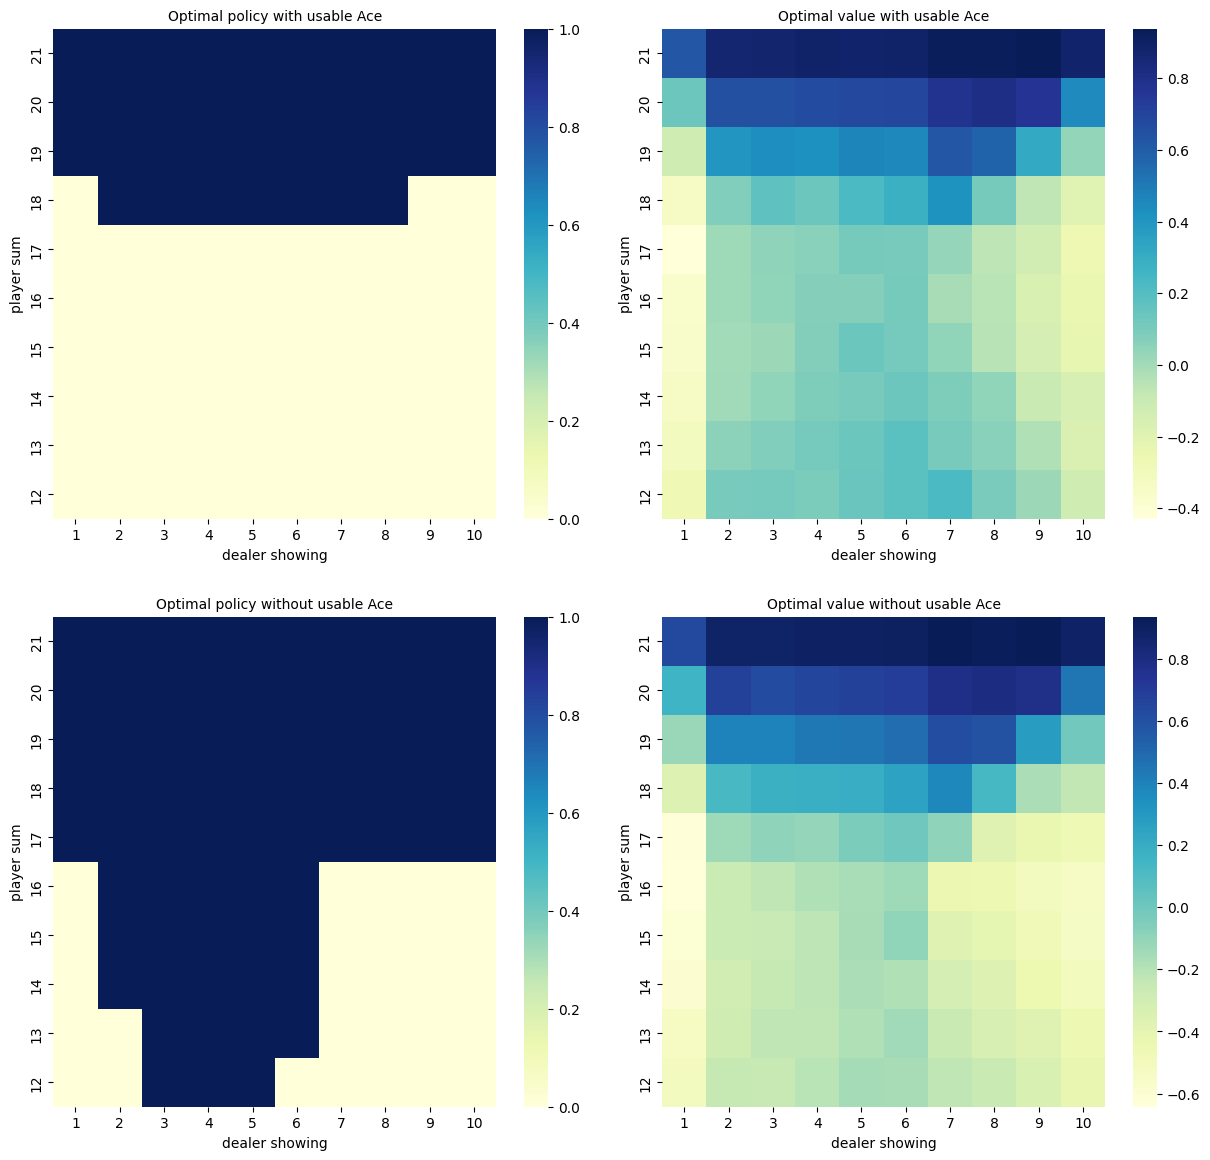

In [32]:
chapter05.figure_5_2()

### 3.9.3.3 基于重要度采样的离轨策略估计

#### 1）离轨策略

所有的学习控制方法都面临一个困境：希望学到的动作可以使随后的智能体行为是最优的，但是为了保证找到最优动作却需要搜索所有动作，采取非最优的行动。为了在遵循试探策略采取行动同时学习到最优策略，一个比较直接的方法是采用两个策略，一个用来学习并最终成为最优策略，称为目标策略（target policy）；另一更具有试探性，用来产生智能体的行动样本，称为行动策略（behavior policy）。因为行动策略学习所用的数据“离开（off）”了带学习的目标策略，因此整个过程被称为离轨策略学习（o↵-policy learning）。在预测任务中，假设希望预测$v_\pi$或$q_\pi$，但需要遵循另一个策略$b(b \neq \pi)$所获得的若干幕样本，其中$\pi$即为目标策略，而$b$为行动策略，两个策略都固定且已知。

为了使用从$b$得到的多幕样本序列去预测$\pi$，要求在$\pi$下发生的每个动作都至少偶尔能在$b$下发生，即，对任意$\pi(a \mid s)>0$，要求$b(a \mid s)>0$，称其为覆盖假设（assumption of coverage）。根据这个假设，在与$\pi$不同的状态中，$b$必须是随机的；另一方面，目标策略$\pi$则可能是确定性的。对应代码中目标策略即为前文定义的`target_policy_player()`；行动策略定义为`behavior_policy_player()`函数，如下，

In [42]:
# function form of behavior policy of player
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

#### 2）重要度采样（importance sampling）

几乎所有的离轨策略方法都采用了重要度采样，其是一种在给定来自其它分布样本条件下，估计某种分布期望值的通用方法。将重要度采样应用于离轨策略学习，对回报值根据其轨迹在目标策略与行动策略中出现的相对概率进行加权，这个相对概率也被称为重要度采样比（importance-sampling ratio）。给定起始状态$S_t$，后续状态-动作轨迹$A_t, S_{t+1}, A_{t+1}, \ldots, S_T $在策略$\pi$下发生的概率是，

$$
\operatorname{Pr}\left\{A_t, S_{t+1}, A_{t+1}, \ldots, S_T \mid S_t, A_{t: T-1} \sim \pi\right\} \\ =\pi\left(A_t \mid S_t\right) p\left(S_{t+1} \mid S_t, A_t\right) \pi\left(A_{t+1} \mid S_{t+1}\right) \cdots p\left(S_T \mid S_{T-1}, A_{T-1}\right) \\ =\prod_{k=t}^{T-1} \pi\left(A_k \mid S_k\right) p\left(S_{k+1} \mid S_k, A_k\right) 
$$

式中， $p$是在*智能体-环境交互接口*公式（1）中定义的状态转移概率函数。因此，在目标函数和行动策略轨迹下的相对概率，即重要度采样比（importance-sampling ratio）是，$\rho_{t: T-1} \doteq \frac{\prod_{k=t}^{T-1} \pi\left(A_k \mid S_k\right) p\left(S_{k+1} \mid S_k, A_k\right)}{\prod_{k=t}^{T-1} b\left(A_k \mid S_k\right) p\left(S_{k+1} \mid S_k, A_k\right)}=\prod_{k=t}^{T-1} \frac{\pi\left(A_k \mid S_k\right)}{b\left(A_k \mid S_k\right)}$。尽管整体轨迹概率值与 MDP 的状态转移概率（未知的）有关，但是分子和分母中完全相同，可以被约分。因此，重要度采样比只与两个策略和样本序列数据相关，而与 MDP 的动态特性（状态转移概率）无关。估计目标策略下的期望回报（价值）时，只从行动策略中估计并不准确，因此应用比例系数$\rho_{t: T-1}$可以调整回报使其具有正确的期望值，$\mathbb{E}\left[\rho_{t: T-1} G_t \mid S_t=s\right]=v_\pi(s)$。

对各幕中的时刻跨幕连续编号，从而使用唯一时刻编号指代特定幕中的特定时刻。并定义所有访问过状态$s$的时刻为$ \mathcal{T}(s)$，用$T(t)$表示在时刻$t$后的首次终止，用$G_t$表示在$t$之后到达$T(t)$时的回报值。那么$\left\{G_t\right\}_{t \in \mathcal{T}(s)}$就是状态$s$对应的回报值，$\left\{\rho_{t: T(t)-1}\right\}_{t \in \mathcal{T}(s)}$是相应的重要度采样比。为了预测$v_\pi(s)$，根据重要度采样比调整回报值并对结果进行平均，有，$V(s) \doteq \frac{\sum_{t \in \mathcal{T}(s)} \rho_{t: T(t)-1} G_t}{|\mathcal{T}(s)|}$，这种通过简单平均实现的重要度采样被称为普通重要度采样（ordinary importance sampling）；如果采用加权平均的方法，有，$V(s) \doteq \frac{\sum_{t \in \mathcal{T}(s)} \rho_{t: T(t)-1} G_t}{\sum_{t \in \mathcal{T}(s)} \rho_{t: T(t)-1}}$，称为加权重要度采样（weighted importance sampling）。

对应的代码定义于`monte_carlo_off_policy()`中，如下：

In [33]:
# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(episodes,initial_state = [True, 13, 2]):
    rhos = []
    returns = []

    for i in range(0, episodes):
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    rhos = np.asarray(rhos)
    returns = np.asarray(returns)
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling

试验21点游戏中状态值的离轨策略估计，并分别采用了普通重要度采样和加权重要度采样。假设初始状态配置为`initial_state = [True, 13, 2]`，即玩家有一张可用的牌A，手牌点数总和为13，而庄家露出的牌为2。通过从这个初始状态开始等概率选择要牌或停牌（行动策略）可以得到采样数据。目标策略只有在手牌点数和达到20或21时停牌。利用目标策略独立生成1亿幕数据后对回报进行平均可以得到状态值为 -0.27726。两种离轨策略方法分别独立运行100次，每次都从估计为0开始学习10,000幕，并将运行100次后的结果平均。从下述结果可以观察到，两种算法的错误率最终都趋近于0，但是加权重要度采样在开始时错误率明显较低。

100%|███████████████████████████████████████████████| 100/100 [00:17<00:00,  5.57it/s]


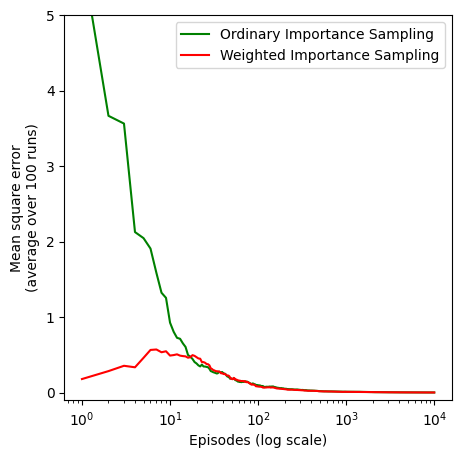

In [36]:
chapter05.figure_5_3(true_value = -0.27726,episodes = 10000,runs = 100)

## 3.9.4 时序差分学习

时序差分（temporal-difference，TD）、动态规划（dynamic programming，DP）和蒙特卡洛（Monte Carlo Methods，MC）这三种方法之间的关系时强化学习（reinforcement learning，RL）领域经常出现的话题。TD 学习结合了 MC 和 DP 方法思想，可以从环境互动的经验中学习策略，而不需要构建关于环境动态特性（状态转移概率）的模型；且无需等待交互的结果（获得一幕结束后的回报），而是基于已获得其它状态的估计值来更新当前状态的价值函数。

### 3.9.4.1 时序差分预测和随机游走

#### 1）时序差分预测

适用于非平稳环境简单的每次访问型 MC 方法可以表示为，$V\left(S_t\right) \leftarrow V\left(S_t\right)+\alpha\left[G_t-V\left(S_t\right)\right],(1)$，式中，$G_t$是时刻$t$真实的回报，$\alpha$是常量步长参数（对比*多臂赌博机*增量式公式（2））。该方法称为常量$\alpha$ MC。MC 方法必须等到一幕结束后才能确定$V(S_t)$的增量，而 TD 方法只需每幕下的一个时刻结束，在$t+1$时刻，使用观察到的$R_{t+1}$和估计值$V(S_{t+1})$进行一次有效更新，有，$V\left(S_t\right) \leftarrow V\left(S_t\right)+\alpha\left[R_{t+1}+\gamma V\left(S_{t+1}\right)-V\left(S_t\right)\right],(2)$。实际上 MC 更新的目标是$G_t$，而 TD 更新的目标是$R_{t+1}+\gamma V\left(S_{t+1}\right)$。这种 TD 方法被称为 TD(0)，或单步 TD（one-step TD）。

在 TD(0)的更新中，括号里的数值是一种误差，衡量的是$S_t$的估计值与更好的估计$R_{t+1}+\gamma V\left(S_{t+1}\right)$之间的差异，$\delta_t \doteq R_{t+1}+  \gamma\left(S_{t+1}\right)-V\left(S_t\right)$，被称为 TD 误差。每个时刻 TD 误差是当前时刻估计的误差，并取决于下一个状态和下一个收益。如果价值函数数组$V$在一幕内没有改变，则 MC 误差可以写为 TD 误差之和，

$$
\begin{aligned}
G_t-V\left(S_t\right) & =R_{t+1}+\gamma G_{t+1}-V\left(S_t\right)+\gamma V\left(S_{t+1}\right)-\gamma V\left(S_{t+1}\right) \\
& =\delta_t+\gamma\left(G_{t+1}-V\left(S_{t+1}\right)\right) \\
& =\delta_t+\gamma \delta_{t+1}+\gamma^2\left(G_{t+2}-V\left(S_{t+2}\right)\right) \\
& =\delta_t+\gamma \delta_{t+1}+\gamma^2 \delta_{t+2}+\cdots+\gamma^{T-t-1} \delta_{T-1}+\gamma^{T-t}\left(G_T-V\left(S_T\right)\right) \\
& =\delta_t+\gamma \delta_{t+1}+\gamma^2 \delta_{t+2}+\cdots+\gamma^{T-t-1} \delta_{T-1}+\gamma^{T-t}(0-0) \\
& =\sum_{k=t}^{T-1} \gamma^{k-t} \delta_k .
\end{aligned}
$$

TD(0) 伪代码如下：

```algorithm
% WGAN
\begin{algorithm}
\caption{Tabular $\mathrm{TD}(0)$ for estimating $v_\pi$}
\begin{algorithmic}
\STATE \textbf{Input:} the policy $\pi$ to be evaluated
\STATE \textbf{Algorithm parameter:} step size $\alpha \in(0,1]$
\STATE \textbf{Initialize} $V(s)$, for all $s \in \mathcal{S}^{+}$, arbitrarily except that $V($ terminal $)=0$
\FOR{(Loop for each episode)}
\STATE \textbf{Initialize} $S$
\FOR{(Loop for each step of episode)}
\STATE $\quad A \leftarrow$ action given by $\pi$ for $S$
\STATE Take action $A$, observe $R, S^{\prime}$
\STATE $\quad V(S) \leftarrow V(S)+\alpha\left[R+\gamma V\left(S^{\prime}\right)-V(S)\right]$
\STATE  $S \leftarrow S^{\prime}$
\ENDFOR 
\ENDFOR 
\end{algorithmic}
\end{algorithm}
```

#### 2）随机游走

马尔可夫收益过程（Markov reward process，MRP）是不包含动作的马尔可夫决策过程，这个过程并不区分价值变化是由环境还是由智能体引起的变化。如图<sup>[Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.]125</sup>，所有阶段都从中心状态$C$开始，在每个时刻以相同的概率向左或向右移动一个状态。幕终止于最左侧或最右侧。终止于最右侧时，有 +1 的收益；除此之外的收益均为0。例如，一个典型的幕可能包含一下“状态-收益”序列：$\mathrm{C}, 0, \mathrm{~B}, 0, \mathrm{C}, 0, \mathrm{D}, 0, \mathrm{E}, 1$。由于这个任务没有折扣，所以每个状态的真实价值是从这个状态开始并终止于最右侧的概率。因此中心状态的真实价值为$v_\pi(C)=0.5$，状态$A,B,C,D,E$的真实价值分别为：$\frac{1}{6}, \frac{2}{6}, \frac{3}{6}, \frac{4}{6}, \frac{5}{6}$。

<img src="../imgs/3_9/3_9_10.png" height='auto' width=600 title="caDesign">

In [5]:
%load_ext autoreload 
%autoreload 2
from usda.migrated_project.RL_an_introduction import chapter06
from usda.migrated_project.RL_an_introduction import chapter07

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


根据上文对 MRP 过程的描述，定义真实价值`TRUE_VALUE`，和一个初始状态价值`VALUES`。

In [41]:
print(f'{chapter06.random_walk.TRUE_VALUE}\n{chapter06.random_walk.VALUES}')

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
[0.  0.5 0.5 0.5 0.5 0.5 1. ]


动作有两个（实际只需定义一个变量），为向左`ACTION_LEFT = 0`和向右`ACTION_RIGHT = 1`。

定义 TD 函数`temporal_difference()`，其中`values[old_state] += alpha * (reward + values[state] - values[old_state])`对应 TD(0)公式（2）.

In [42]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards

案例比较了 TD(0) 和$\alpha$ MC 两种方法，因此定义$\alpha$ MC方法的函数`monte_carlo()`，其中`values[state_] += alpha * (returns - values[state_])`对应$\alpha$ MC公式（1）。

In [43]:
# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])
    return trajectory, [returns] * (len(trajectory) - 1)

下图左显示经历不同数量的幕采样序列之后，运行一次 TD(0) 所得到的价值估计值。在 100 幕后，估计值已经非常接近真实值。由于使用了常数步长参数（配置$\alpha=0.1$），估计值会反映较近若干幕的结果，不规律的上下波动。右图则给出了不同$\alpha$的取值，及 TD(0)和$\alpha$ MC 两种方法的计算结果。从结果可以观察到 TD(0) 要好于$\alpha$ MC。

100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 337.79it/s]


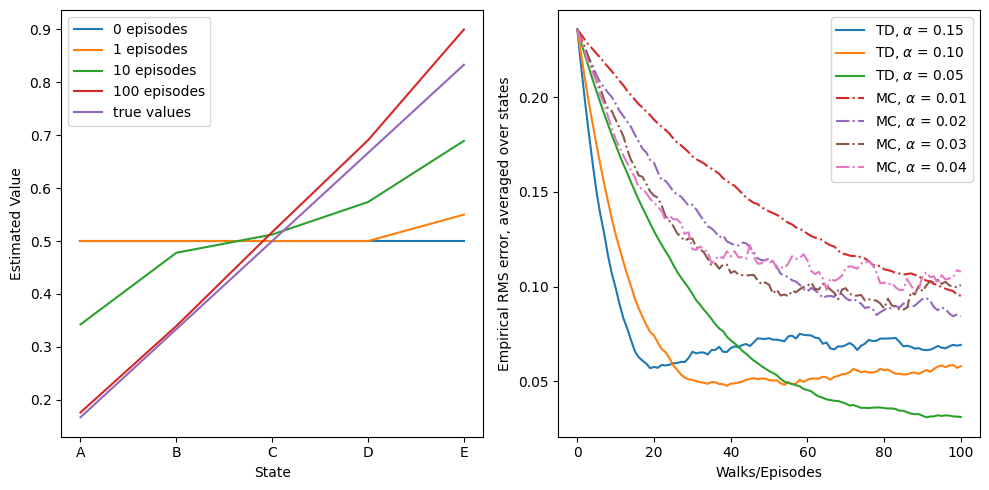

In [55]:
chapter06.example_6_2()

#### 3）批量更新的随机游走

如果价值函数仅根据所有增量的和更新一次，然后利用新的值函数再次处理所有可用的经验，产生新的总增量，依此类推，直至价值函数收敛，称为批量更新（batch updating）（因为只有处理了整批的训练数据后才进行更新）。在批量更新下，只要选择足够小的步长参数$\alpha$， TD(0)就能确定收敛到与$\alpha$无关的唯一结果。对于批量更新的随机游走，每经过新的一幕序列之后，之前所有幕的数据就被视为一个批次。TD(0)和$\alpha$ MC 不断使用这些批次进行逐次更新。 最后将所得的价值函数与$v_\pi$进行比较，绘制在5个状态下的平均均方根误差（以整个试验的100次独立重复为基础）的学习曲线。对应的代码为`batch_updating()`函数。

In [65]:
# Figure 6.2
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001,runs = 100):
    # perform 100 independent runs    
    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        current_values[1:6] = -1
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

100%|███████████████████████████████████████████████| 100/100 [00:35<00:00,  2.79it/s]


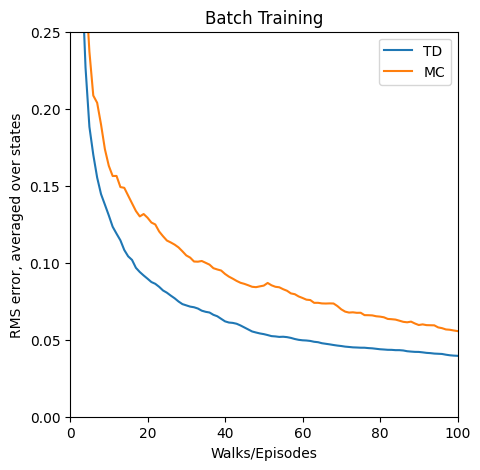

In [64]:
chapter06.figure_6_2(episodes = 100 + 1,alpha=0.001,runs = 100)

### 3.9.4.2 Sarsa：同轨策略下的时序差分控制

#### 1）Sarsa

同轨策略下的时序差分（on-policy TD）控制方法，先学习动作价值函数，对所有状态$s$和动作$a$，估计出当前行动策略下对应的$q_\pi(s,a)$。状态-动作二元组的“一幕数据”是状态和动作交替出现的序列，如图<sup>[2]129</sup>，

<img src="../imgs/3_9/3_9_11.png" height='auto' width=600 title="caDesign">

前文随机游走的试验讨论了状态之间的转移并学习状态价值函数，而对于“状态-动作”二元组之间的转移并学习“状态-动作”二元组的价值，在数学形式上两者相同：都是带有收益过程的马尔科夫链。确保状态值在 TD(0) 下收敛的定理同样适用于动作价值函数，有，$Q\left(S_t, A_t\right) \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma Q\left(S_{t+1}, A_{t+1}\right)-Q\left(S_t, A_t\right)\right], (3)$。每当从非终止状态的$S_t$出现一次转移之后，就进行一次公式（3）的更新。如果$S_{t+1}$是终止状态，则$Q\left(S_{t+1}, A_{t+1}\right)$定义为0。这个更新规则用到了描述这个事件的五元组$\left(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1}\right)$中的所有元素，因此称为 Sarsa。

采用$\epsilon$-贪心（$\epsilon$-greedy）策略，使得“状态-动作”二元组可以被无限多次的访问到，Sarsa算法收敛到最优策略和动作价值函数，伪代码如下，

```algorithm
% WGAN
\begin{algorithm}
\caption{Sarsa (on-policy TD control) for estimating $Q \approx q_*$}
\begin{algorithmic}
\STATE \textbf{Algorithm parameter:} step size $\alpha \in(0,1]$, small $\varepsilon>0$
\STATE \textbf{Initialize} $Q(s, a)$, for all $s \in \mathcal{S}^{+}, a \in \mathcal{A}(s)$, arbitrarily except that $Q($ terminal,$\cdot)=0$
\FOR{(Loop for each episode)}
\STATE \textbf{Initialize} $S$
\STATE Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\varepsilon$-greedy)
\FOR{(Loop for each step of episode)}
\STATE Take action $A$, observe $R, S^{\prime}$
\STATE Choose $A^{\prime}$ from $S^{\prime}$ using policy derived from $Q$ (e.g., $\varepsilon$-greedy)
\STATE $Q(S, A) \leftarrow Q(S, A)+\alpha\left[R+\gamma Q\left(S^{\prime}, A^{\prime}\right)-Q(S, A)\right]$
\STATE  $S \leftarrow S^{\prime} ; A \leftarrow A^{\prime} $;
\ENDFOR 
\STATE until $S$ is terminal
\ENDFOR 
\end{algorithmic}
\end{algorithm}
```

#### 2）有风的网格世界

<img src="../imgs/3_9/3_9_12.jpg" height='auto' width=500 title="caDesign">

在一个$7 \times 10$的网格中，设置起始状态 S 为`START = [3, 0]`，目标状态 G 为`GOAL = [3, 7]`；智能体有4个动作，上下左右，定义为`ACTION_UP = 0; ACTION_DOWN = 1; ACTION_LEFT = 2; ACTION_RIGHT = 3`，置于一个列表为`ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]`；每列网格都存在一个向上的风向，但风力的大小（向上移动的格数）可能存在差异，定义为`WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]`。如果智能体有一个向右的动作，但是向上为1的风力使得该智能体在向右移动一个单元时，也向上移动一个单元。如果智能体处于上下左右边界，则将其推往网格之外对应的动作及风力的作用对其无效。定义`step()`函数描述状态-动作策略，代码如下，

In [3]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

这个任务中，在到达目标 G 之前，每步会收到恒定为 -1 的收益，定义`REWARD = -1.0`；同时配置$\epsilon$-贪心（开发/试探的权衡中）策略的$\epsilon=0.1$，即`EPSILON = 0.1`；配置 Sarsa 的步长大小$\alpha=0.5$，即`ALPHA = 0.5`；对所有$s,a$初始化为$Q(s,a)=0$，即`q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))`。定义 Sarsa 同轨策略下的 TD 控制函数`episode()`如下：

In [4]:
# play for an episode
def episode(q_value):
    # track the total time steps in this episode
    time = 0

    # initialize state
    state = START

    # choose an action based on epsilon-greedy algorithm
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # keep going until get to the goal state
    while state != GOAL:
        next_state = step(state, action)
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # Sarsa update
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    return time

打印结果为每一幕的时刻数，曲线越趋于平缓，每一幕的时刻数就越多，从起始状态到目标状态的步数就越多，即 Sarsa 算法还没收敛到最优策略和动作价值函数；而曲线越陡，每一幕的时刻数就越少，从起始状态到目标状态的步数就越少，即 Sarsa 算法逐步收敛到最优策略和动作价值函数。同时打印迭代 500 幕之后的最优动作策略。

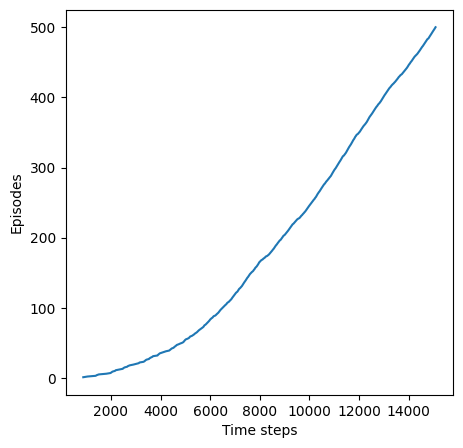

Optimal policy is:
['L', 'R', 'R', 'R', 'R', 'R', 'U', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'D']
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'D', 'D']
['D', 'D', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['D', 'R', 'D', 'R', 'R', 'U', 'U', 'D', 'L', 'L']
['R', 'U', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [2]:
chapter06.figure_6_3()

### 3.9.4.3  Q 学习：离轨策略下的时序差分控制

#### 1）Q 学习

离轨策略下的时序差分控制算法被称为 Q 学习（Q-learning，QL），定义为$Q\left(S_t, A_t\right) \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma \max _a Q\left(S_{t+1}, a\right)-Q\left(S_t, A_t\right)\right]$。QL 中待学习的动作价值函数$Q$采用了对最优动作价值函数$q_*$的直接近似作为学习目标，而与用于生成智能体决策序列轨迹的行动策略是什么无关；而 Sarsa 的学习目标中使用的是待学习的动作价值本身，需要知道下一时刻的动作$A_{t+1}$，因此与生成数据的行动策略相关。QL 的伪代码如下，

```algorithm
% WGAN
\begin{algorithm}
\caption{Q-learning (off-policy TD control) for estimating $\pi \approx \pi_*$}
\begin{algorithmic}
\STATE \textbf{Algorithm parameter:} step size $\alpha \in(0,1]$, small $\varepsilon>0$
\STATE \textbf{Initialize} $Q(s, a)$, for all $s \in \mathcal{S}^{+}, a \in \mathcal{A}(s)$, arbitrarily except that $Q($ terminal,$\cdot)=0$
\FOR{(Loop for each episode)}
\STATE \textbf{Initialize} $S$
\FOR{(Loop for each step of episode)}
\STATE Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\varepsilon$-greedy)
\STATE Take action $A$, observe $R, S^{\prime}$
\STATE $Q(S, A) \leftarrow Q(S, A)+\alpha\left[R+\gamma \max _a Q\left(S^{\prime}, a\right)-Q(S, A)\right]$
\STATE $S \leftarrow S^{\prime}$
\ENDFOR 
\STATE until $S$ is terminal
\ENDFOR 
\end{algorithmic}
\end{algorithm}
```

#### 2）在悬崖边上行走

<img src="../imgs/3_9/3_9_13.png" height='auto' width=500 title="caDesign">

上图<sup>[2]132</sup>构建了一个网格，包含起始状态 S 和目标状态 G ，环境中包含一行悬崖，如果动作导致掉入该一行悬崖则收益为-100，并同时将智能体送回起点；而其它的转移得到的收益都是-1。计算比较同轨策略（Sarsa）和离轨策略（QL）两类方法间的区别，其中 QL 对应`q_learning()`函数如下，

In [ ]:
# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

Sarsa 对应`sarsa()`函数如下代码，并通过配置`expected=True`参数，包含了期望 Sarsa 算法。

In [ ]:
# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

从计算结果来看，QL 学习到了最优策略，沿着悬崖边上走的策略。但是，由于动作是通过$\epsilon$-贪心的方式选择，因此执行这个策略时，智能体会偶尔掉入悬崖；而 Sarsa 则考虑了动作被选取的方式，学习到了一条通过网格上半部分的路径，虽然路径更长但更安全。

100%|█████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


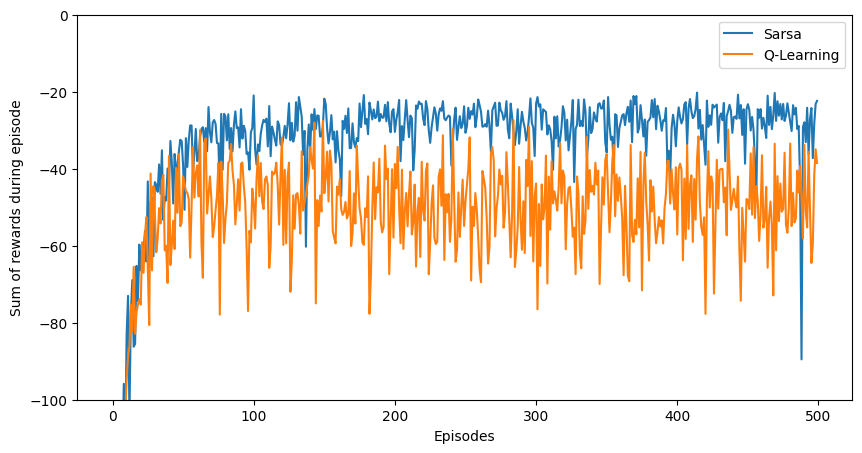

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'L', 'L', 'R', 'D']
['U', 'R', 'U', 'U', 'U', 'L', 'U', 'R', 'R', 'R', 'R', 'D']
['U', 'R', 'U', 'U', 'R', 'R', 'U', 'U', 'L', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['R', 'D', 'U', 'R', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['D', 'R', 'R', 'D', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


In [9]:
chapter06.figure_6_4(figsize=(10,5))

### 3.9.4.4 期望 Sarsa

将 QL 中对下一个“状态-动作”二元组取最大值这一步换成取期望的学习算法，更新规则为，

$$
\begin{aligned}
Q\left(S_t, A_t\right) & \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma \mathbb{E}\left[Q\left(S_{t+1}, A_{t+1}\right) \mid S_{t+1}\right]-Q\left(S_t, A_t\right)\right] \\
& \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma \sum_a \pi\left(a \mid S_{t+1}\right) Q\left(S_{t+1}, a\right)-Q\left(S_t, A_t\right)\right]
\end{aligned}
$$

给定下一个状态$S_{t+1}$，该算法确定向期望意义上的 Sarsa 算法所决定的方向上移动，因此该算法称为期望 Sarsa（Expected Sarsa）。

期望 Sarsa 计算上较之 Sarsa 复杂，但是消除了因为随机选择$A_{t+1}$而产生的方差。继续使用悬崖边上行走的任务，比较期望 Sarsa、Sarsa 和 QL 结果如下。期望 Sarsa 保持了 Sarsa 优于 QL 的显著优势。在步长参数$\alpha$大量不同的取值下，期望 Sarsa 都显著的优于 Sarsa。同时，Sarsa 仅仅在$\alpha$值较小时能够有良好的长期表现，而启动期瞬态表现则不如意。因此期望 Sarsa 相比 Sarsa 在试验中表现出明显优势。

100%|█████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.17s/it]


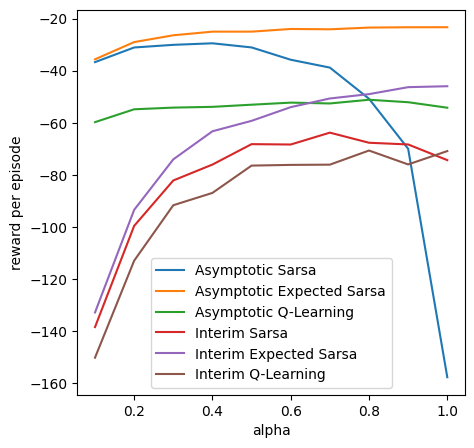

In [16]:
chapter06.figure_6_6()

### 3.9.4.5 $n$步自举法（$n$-step Bootstrapping）

#### 1）$n$步时序差分方法

$n$步时序差分方法（$n$-step TD）是 MC 和 TD(0) 更一般的推广。MC 方法根据从某一状态开始到终止状态的收益序列，对这个状态的价值进行更新；而 TD(0) 则只根据后面的单个即使收益，在下一个后继状态价值估计值的基础上进行自举更新。$n$步自举法为一种介于 MC 和 TC(0)之间的方法，根据多个中间时刻的收益进行更新（多于一个时刻的收益，但又不是终止状态的所有收益）。$n$步更新的方法依然属于 TD 方法，其前面状态的估计值会根据它与后继状态的估计值的差异进行更新。时序差分量被扩展成$n$步的方法称为$n$步时序差分（$n$-step TD）方法。

考虑根据“状态-收益”序列（省略了动作）$S_t, R_{t+1}, S_{t+1}, R_{t+2}, \ldots, R_T, S_T$进行状态$S_t$的更新。在基于 MC 的更新中，$ v_\pi\left(S_t\right)$的估计值会沿着完整回报的方向进行更新，即$G_t \doteq R_{t+1}+\gamma R_{t+2}+\gamma^2 R_{t+3}+\cdots+\gamma^{T-t-1} R_T$，式中，$T$是终止状态的时刻，$G_t$是更新的目标，为累积收益（回报）。在 TD(0)中更新的目标，是即时收益加上后继状态的价值函数估计值乘以折扣系数，称为单步回报$G_{t: t+1} \doteq R_{t+1}+\gamma V_t\left(S_{t+1}\right)$，式中，$V_t: \mathcal{S} \rightarrow \mathbb{R}$是在$t$时刻$v_\pi$的估计值。$G_{t: t+1}$的下标表示这是一种截断回报，它由当前时刻$t$到时刻$t+1$的累积收益和折扣回报$\gamma V_t\left(S_{t+1}\right)$组成。其中$\gamma V_t\left(S_{t+1}\right)$代替了完整回报中的$\gamma R_{t+2}+\gamma^2 R_{t+3}+\ldots+\gamma^{T-t-1} R_T$。类似，将其扩展到两步情况，更新的目标是两步回报$G_{t: t+2} \doteq R_{t+1}+\gamma R_{t+2}+\gamma^2 V_{t+1}\left(S_{t+2}\right)$，式中，$\gamma^2 V_{t+1}\left(S_{t+2}\right)$代替了$\gamma R_{t+3}+\gamma^2 R_{t+4}+\cdots+\gamma^{T-t-1} R_T$。类似，任意$n$步更新的目标是$n$步回报$G_{t: t+n} \doteq R_{t+1}+\gamma R_{t+2}+\cdots+\gamma^{n-1} R_{t+n}+\gamma^n V_{t+n-1}\left(S_{t+n}\right)$，式中，$n \geqslant 1,0 \leqslant t<T-n$。所有的$n$步回报都可以看作完整回报的近似，即在$n$步后截断得到$n$步的回报，然后其余部分用$V_{t+n-1}\left(S_{t+n}\right)$来替代。如果$t+n \geqslant T$（即$n$步回报超出了终止状态），则其余部分的值都为0，即$n$步回报等于完整的回报（如果$t+n \geqslant T$，则$\left.G_{t: t+n}=G_t\right)$）。

计算$n$步回报（$n>1$）涉及若干将来时刻的收益和状态，在时刻$t+n$时获取到$R_{t+n}$和 $V_{t+n-1}$后才计算，一个比较自然的基于$n$步回报的状态价值函数更新算法是$V_{t+n}\left(S_t\right) \doteq V_{t+n-1}\left(S_t\right)+\alpha\left[G_{t: t+n}-V_{t+n-1}\left(S_t\right)\right], 0 \leqslant t<T$，而对于任意其它状态$s\left(s \neq S_t\right)$的价值估计保持不变：$V_{t+n}(S)=V_{t+n-1}(S)$。这个算法被称为$n$步时序差分（$n$步 TD）算法。因为在最开始的$n-1$个时刻，价值函数不会被更新，因此在终止时刻后还将执行对应次数的更新，其伪代码如下，

```algorithm
% WGAN
\begin{algorithm}
\caption{$n$-step TD for estimating $V \approx v_\pi$}
\begin{algorithmic}
\STATE \textbf{Input:} a policy $\pi$
\STATE \textbf{Algorithm parameter:} step size $\alpha \in(0,1]$, a positive integer $n$
\STATE \textbf{Initialize} $V(s)$ arbitrarily, for all $s \in \mathcal{S}$
\STATE All store and access operations (for $S_t$ and $R_t$ ) can take their index $\bmod n+1$
\FOR{(Loop for each episode)}
\STATE \textbf{Initialize and store} $S_0 \neq$ terminal
\STATE $T \leftarrow \infty$
\FOR{(Loop for $t=0,1,2, \ldots$ )}
\IF{$t<T$}
\STATE Take an action according to $\pi\left(\cdot \mid S_t\right)$
\STATE Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$
\IF{$S_{t+1}$ is terminal}
\STATE $T \leftarrow t+1$
\ENDIF
\ENDIF
\STATE  $\tau \leftarrow t-n+1 \quad$ ( $\tau$ is the time whose state's estimate is being updated)
\IF{$\tau \geq 0$}
\STATE $G \leftarrow \sum_{i=\tau+1}^{\min (\tau+n, T)} \gamma^{i-\tau-1} R_i$
\IF{$\tau+n<T$}
\STATE $G \leftarrow G+\gamma^n V\left(S_{\tau+n}\right)$
\ENDIF
\STATE $V\left(S_\tau\right) \leftarrow V\left(S_\tau\right)+\alpha\left[G-V\left(S_\tau\right)\right]$
\ENDIF
\ENDFOR 
\STATE Until $\tau=T-1$
\ENDFOR 
\end{algorithmic}
\end{algorithm}
```

#### 2）$n$步时序差分方法在随机游走上的应用

`temporal_difference()`函数实现了$n$步时序差分方法，如下代码。

In [3]:
# n-steps TD method
# @value: values for each state, will be updated
# @n: # of steps
# @alpha: # step size
def temporal_difference(value, n, alpha):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            if np.random.binomial(1, 0.5) == 1:
                next_state = state + 1
            else:
                next_state = state - 1

            if next_state == 0:
                reward = -1
            elif next_state == 20:
                reward = 1
            else:
                reward = 0

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += pow(GAMMA, t - update_time - 1) * rewards[t]
            # add state value to the return
            if update_time + n <= T:
                returns += pow(GAMMA, n) * value[states[(update_time + n)]]
            state_to_update = states[update_time]
            # update the state value
            if not state_to_update in END_STATES:
                value[state_to_update] += alpha * (returns - value[state_to_update])
        if update_time == T - 1:
            break
        state = next_state

下图展示了一个有19个状态（`N_STATES = 19`）随机游走过程的试验结果，初始状态为`START_STATE = 10`，其中在左边的收益为-1，所有初始状态价值为0。真实价值为`TRUE_VALUE`。

In [6]:
# true state value from bellman equation
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[-1] = 0
print(TRUE_VALUE)

[ 0.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  0. ]


图中展示的为最开始的10幕，并重复100次的平均结果。从结果可以观察到，$n$取中间大小的值时效果最好，例如当步长$\alpha=0.4$，$n=4$时，每幕终止时的价值函数的估计值和真实值的均方根误差的均值开方最小。

100%|███████████████████████████████████████████████| 100/100 [04:21<00:00,  2.61s/it]


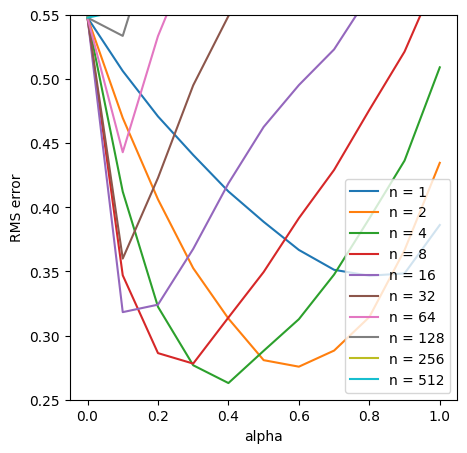

In [2]:
chapter07.figure7_2()

## 3.9.5 基于表格型方法的规划和学习

### 3.9.5.1 Dyna-Q 和迷宫

<img src="../imgs/3_9/3_9_14.jpg" height='auto' width=350 title="caDesign">

上图<sup>[2]162</sup>中的经验（experience）对应着学习到的$s,a,r,s^\prime$（状态、动作、收益和下一个状态）的一个序列。红色虚线圈部分为前文中阐述强化学习（reinforcement learning，RL）的一个结构，使用经验直接更新（改善）价值函数和策略。因为没有使用红色虚线圈外部的模型（model），为无模型（model-free）的强化学习，称为直接强化学习（direct RL）。外部新加入（环境）的模型，指一个智能体可以用来预测环境对其动作的反应的任何事物。给定一个状态和一个动作，作为环境的反应结果，模型就会产生后继状态和下一个收益的预测。如果模型时随机的，那么后继状态和下一个收益有多种可能，每个都有一定的发生概率。一些模型生成对所有可能结果的描述及其对应的概率分布，称为分布模型；如果从所有可能性中通过概率分布采样得到一个确定的结果，则称为样本模型。模型是用来模拟环境和产生模拟经验的。使用经验来改进模型（使模型与现实环境更精确的匹配）称为模型学习（model-learning）。而将模型作为输入生成或改进与它进行交互的策略计算过程，即更新价值函数和策略的过程称为规划（planning）。用模型和规划改善价值函数和策略的方式称为间接强化学习（indirect RL）。上图包含有直接强化学习和基于模型与规划的间接强化学习的简单架构称为 Dyna-Q 算法。Dyna-Q 算法伪代码如下：

```algorithm
% WGAN
\begin{algorithm}
\caption{Tabular Dyna-Q}
\begin{algorithmic}
\STATE \textbf{Initialize} $Q(s, a)$ and $\operatorname{Model}(s, a)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}(s)$
\WHILE{(\textbf{Loop forever})}
\STATE (a) $S \leftarrow$ current (nonterminal) state
\STATE (b) $A \leftarrow \varepsilon$-greedy $(S, Q)$
\STATE (c) Take action $A$; observe resultant reward, $R$, and state, $S^{\prime}$
\STATE (d) $Q(S, A) \leftarrow Q(S, A)+\alpha\left[R+\gamma \max _a Q\left(S^{\prime}, a\right)-Q(S, A)\right]$
\STATE (e) $\operatorname{Model}(S, A) \leftarrow R, S^{\prime}$ (assuming deterministic environment)
\FOR{(Loop repeat $n$ times)}
\STATE $S \leftarrow$ random previously observed state
\STATE $A \leftarrow$ random action previously taken in $S$
\STATE $R, S^{\prime} \leftarrow \operatorname{Model}(S, A)$
\STATE $Q(S, A) \leftarrow Q(S, A)+\alpha\left[R+\gamma \max _a Q\left(S^{\prime}, a\right)-Q(S, A)\right]$
\ENDFOR 
\ENDWHILE
\end{algorithmic}
\end{algorithm}
```

为了更清晰的理解模型和规划，及与直接强化学习的结合方式，以一个迷宫游戏的 Dyan-Q 实现为例阐述。

<img src="../imgs/3_9/3_9_15.jpg" height='auto' width=350 title="caDesign">

上图为一个$9 \times 6$的网格，其中红色单元为屏障（障碍物），总共占据7个单元，因此总共状态有47个。初始状态为含 S 单元，目标状态为含 G 的单元。每个状态含4个动作，上下左右，这使得智能体一定走到边邻接的单元中的某个状态，除非被屏障或迷宫的边缘阻挡。当遇到屏障时，智能体仍保持它原来的位置。对于收益的配置，除了目标状态为 +1 外，其它转移收益均为0。智能体到达目标状态后，返回到初始状态以开始新的一幕。这是一个带折扣的分幕式任务，配置$\gamma=0.95$。定义类`Maze`（查看`USDA`库的迁移代码或者 Shangtong Zhang 的源码），包括迷宫的所有信息。环境的模型定义为`TrivialModel`类，其中`feed()`方法不断存储和更新可获得的每一时刻的经验；`sample()`方法从以前的经验中随机采样。

In [1]:
%load_ext autoreload 
%autoreload 2
from usda.migrated_project.RL_an_introduction import chapter08

In [ ]:
# Trivial model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

Dyna-Q 算法的基本架构定义为`dyna_q()`函数，其中注释`# Q-Learning update`部分标识了直接强化学习部分；`# sample experience from the model`部分标识了基于模型和规划的间接强化学习部分。

In [ ]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])

        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    return steps

配置步长参数$\alpha=0.1$，和“试探”参数$\epsilon=0.1$；比较规划幕数为0（无规划）、5和50时的结果，图中曲线表示在每幕到达目标状态时智能体所花费的步数，这个数字是 30 次（`runs=30`）重复试验的平均结果。从结果中可以观察到，无规划智能体用了大约25幕才取得最优性能，而$n=5$的智能体只用了5幕；$n=50$的智能体只用了3幕。

In [5]:
dynaParams=chapter08.DynaParams()
print(f'gamma={dynaParams.gamma}\nepsilon={dynaParams.epsilon}\nalpha={dynaParams.alpha}')

gamma=0.95
epsilon=0.1
alpha=0.1


100%|█████████████████████████████████████████████████| 30/30 [03:30<00:00,  7.00s/it]


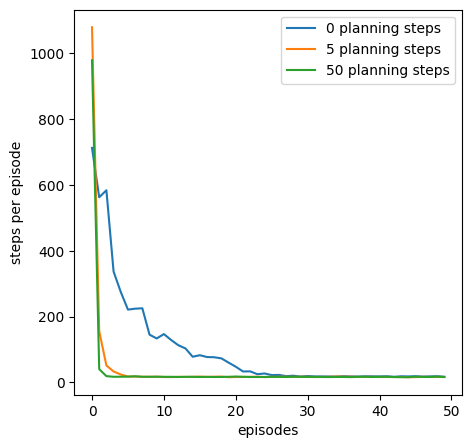

In [6]:
chapter08.figure_8_2(runs = 30,episodes = 50,planning_steps = [0, 5, 50])

### 3.9.5.2  Dyna-Q+ 和环境的变化

当迷宫的环境发生改变，例如下图 A 中的屏障开始是右侧打开（图左），而后调整为左侧打开而右侧关闭（图右）；图 B 中，开始仅左侧打开（图左）， 而后右侧同时打开（图右），对于 Dyna-Q 算法，以前正确的策略并没有反应出这些改变时，智能体的学习则会遇到困难，这些环境的改变对于智能体而言可能在很长时间，甚至一直都不会被检测到。

<img src="../imgs/3_9/3_9_16.jpg" height='auto' width=500 title="caDesign">

类似开发/试探的权衡，Dyna-Q+借助启发式算法，使智能体跟踪每个“状态-动作”二元组，记录它自上一次与环境进行真实交互出现以来，已经经过了多少时刻。时间越长就越有理由推测这个二元组相关的环境动态特性会产生变化，即关于它的模型不是正确的。为了鼓励测试长期未出现过的动作，在模型中为该动作相关的模拟经验设置“额外收益”提供给智能体，该“额外收益”为$r+\kappa \sqrt{\tau}$，式中，$r$是模型对单步转移的收益，$\tau$是距上次交互的时长（多少时刻），$\kappa$是一个比较小的数字，对应的代码`reward += self.time_weight * np.sqrt(self.time - time)`。定义Dyna-Q+算法实现的函数`TimeModel()`。

In [ ]:
# Time-based model for planning in Dyna-Q+
class TimeModel:
    # @maze: the maze instance. Indeed it's not very reasonable to give access to maze to the model.
    # @timeWeight: also called kappa, the weight for elapsed time in sampling reward, it need to be small
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, maze, time_weight=1e-4, rand=np.random):
        self.rand = rand
        self.model = dict()

        # track the total time
        self.time = 0

        self.time_weight = time_weight
        self.maze = maze

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        self.time += 1
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()

            # Actions that had never been tried before from a state were allowed to be considered in the planning step
            for action_ in self.maze.actions:
                if action_ != action:
                    # Such actions would lead back to the same state with a reward of zero
                    # Notice that the minimum time stamp is 1 instead of 0
                    self.model[tuple(state)][action_] = [list(state), 0, 1]

        self.model[tuple(state)][action] = [list(next_state), reward, self.time]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward, time = self.model[state][action]

        # adjust reward with elapsed time since last vist
        reward += self.time_weight * np.sqrt(self.time - time)

        state = deepcopy(state)
        next_state = deepcopy(next_state)

        return list(state), action, list(next_state), reward

对于 A 类型迷宫环境的改变，可以从下述计算结果观察到，经过 1000 次学习后，曲线变平，表明在这一段时刻内智能体没有得到收益，它们在屏障（被堵住的开口）后面徘徊，但过了一段时间，它们依然能够学习到新的最优动作。Dyna-Q+ 要优于Dyna-Q。

100%|█████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.02s/it]


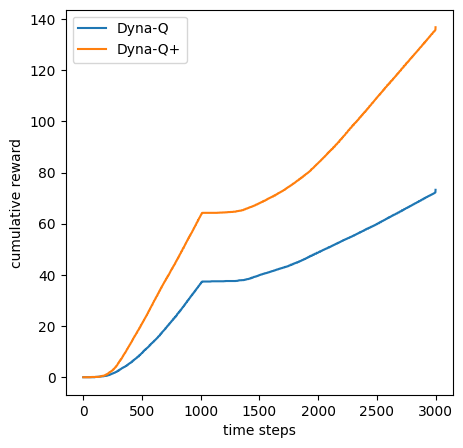

In [7]:
chapter08.figure_8_4()

对于 B 类型迷宫环境的改变， 3000 步以后，打开了一个新开口，但 Dyna-Q 并未切换到捷径，而Dyna-Q+ 累积回报进一步增加，表明发现了这一捷径。

100%|███████████████████████████████████████████████████| 5/5 [03:29<00:00, 41.96s/it]


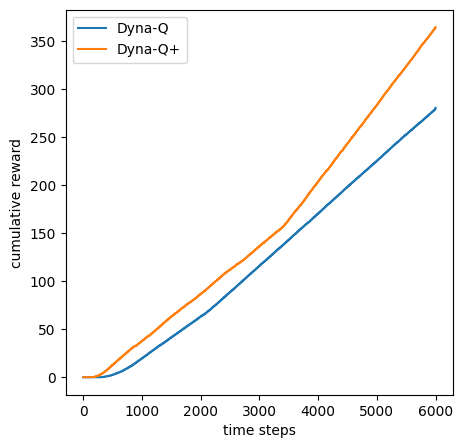

In [8]:
chapter08.figure_8_5()

### 3.9.5.3 优先遍历

对于迷宫的案例，如果智能体从一个零值状态转移到另一个零值状态（只有目标状态的收益为 +1，否则均为 0），价值更新没有变化。只有跳入目标状态之前的状态或者从这个状态跳出的转移过程才会导致价值估计的改变。使用均匀的模拟转移，在到达一个有用的更新之前将进行很多没用的更新，降低了有效更新的效率。因此，可以从目标状态和使得价值发生变化的任何状态进行反向计算，称为规划计算的反向聚焦（backward focusing）。当有用更新的边界不断反向推演传播时，它的范围常常迅速扩大，产生许多可以有效更新的“状态-动作”二元组，但并不是所有这些二元组同样有用，因此可以按照价值改变的大小进行优先级排序。队列头部的“状态-动作”二元组被更新时，也会计算它对其前导“状态-动作”二元组的影响。如果这些影响大于某个较小的阈值，就把相应的前导“状态-动作”二元组也插入到优先队列中（如果已经在队列，则保留优先级高的一个）。通过这种方法，价值变化的影响被有效反向传播直至影响消失。优先遍历的伪代码如下，

```algorithm
% WGAN
\begin{algorithm}
\caption{Prioritized sweeping for a deterministic environment}
\begin{algorithmic}
\STATE \textbf{Initialize} $Q(s, a)$ and $\operatorname{Model}(s, a)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}(s)$
\WHILE{(\textbf{Loop forever})}
\STATE (a) $S \leftarrow$ current (nonterminal) state
\STATE (b) $A \leftarrow \operatorname{policy}(S, Q)$
\STATE (c) Take action $A$; observe resultant reward, $R$, and state, $S^{\prime}$
\STATE (d) $\operatorname{Model}(S, A) \leftarrow R, S^{\prime}$
\STATE (e) $P \leftarrow\left|R+\gamma \max _a Q\left(S^{\prime}, a\right)-Q(S, A)\right|$.
\STATE (f) if $P>\theta$, then insert $S, A$ into $P Queue$  with priority $P$
\FOR{(Loop repeat $n$ times, while $P Queue$ is not empty)}
\STATE $S, A \leftarrow \operatorname{first}(P Queue )$
\STATE $R, S^{\prime} \leftarrow \operatorname{Model}(S, A)$
\STATE $R, S^{\prime} \leftarrow \operatorname{Model}(S, A)$
\STATE $Q(S, A) \leftarrow Q(S, A)+\alpha\left[R+\gamma \max _a Q\left(S^{\prime}, a\right)-Q(S, A)\right]$
\FOR{(Loop for all $\bar{S}, \bar{A}$ predicted to lead to $S$)}
\STATE $\bar{R} \leftarrow$ predicted reward for $\bar{S}, \bar{A}, S$
\STATE $P \leftarrow\left|\bar{R}+\gamma \max _a Q(S, a)-Q(\bar{S}, \bar{A})\right| .$
\STATE if $P>\theta$ then insert $\bar{S}, \bar{A}$ into $P Q u e u e$ with priority $P$
\ENDFOR 
\ENDFOR 
\ENDWHILE
\end{algorithmic}
\end{algorithm}
```

从下述有无优先遍历的 Dyna-Q 对比结果中可以发现，在不同网格单元数量（状态数）不同的情况下，达到最优解所需更新数，优先遍历相对较少，具有更明显的优势。

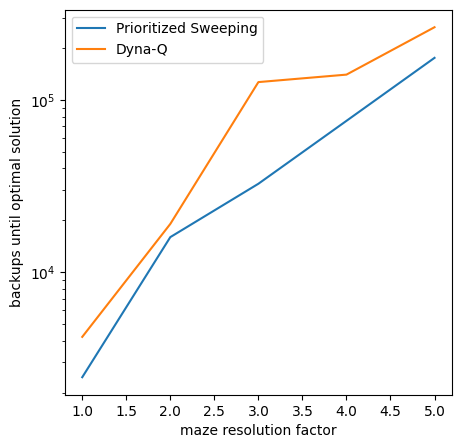

In [10]:
chapter08.example_8_4()

### 3.9.5.4 期望更新与采样更新的对比

讨论不同类型的价值函数更新主要沿着三个维度产生变化，一是，是更新状态价值还是动作价值；二是，估计的价值对应的是最优策略还是给定的任意策略。上述两个维度组合出四类更新，用于近似四个价值函数：$q^*,v^*,q_\pi,v_\pi$；最后一个维度是采用期望更新还是采样更新。因为没有受到采样误差的影响，期望更新肯定会产生更好的估计，但是需要更多的计算。讨论一种将期望更新和采样更新用于近似$q^*$的特殊例子，其中状态和动作都是离散的，近似价值函数$Q$采用表格来表示，环境模型的估计采用$p\left(s^{\prime}, r \mid s, a\right)$。则“动态-动作”二元组$s,a$的期望更新是$Q(s, a) \leftarrow \sum_{s^{\prime}, r} \hat{p}\left(s^{\prime}, r \mid s, a\right)\left[r+\gamma \max _{a^{\prime}} Q\left(s^{\prime}, a^{\prime}\right)\right]$；与之对应的$s,a$的采样更新则是一种类似$Q$学习的更新。给定后继状态$S^\prime$和收益$R$（来自模型）的采样更新是$Q(s, a) \leftarrow Q(s, a)+\alpha\left[R+\gamma \max _{a^{\prime}} Q\left(S^{\prime}, a^{\prime}\right)-Q(s, a)\right]$，式中，$\alpha$是一个通常为正数的步长参数。对于一个特定的初始二元组$s,a$，设$b$是分支因子（对于所有可能的后继状态$s^\prime$，其中$\left.\hat{p}\left(s^{\prime} \mid s, a\right)>0\right)$的数目），则这个二元组期望更新需要的计算量大约是采样更新的$b$倍。

下述试验显示了在不同分支因子$b$下，期望更新和采样更新的估计误差对计算次数的函数变化。其中所有$b$个后继状态都是等概率发生的，且初始估计的误差是1。后继状态的价值假定是正确的，所以期望更新在完成时会将误差缩小到0。在这种情况下，采样更新会使得误差以比例系数$\sqrt{\frac{b-1}{b t}}$减小，式中，$t$是已经进行过的采样更新的次数（假设采样平均值，$\alpha=1/t$）。从计算结果来看，对于中等大小的$b$来说，估计误差的大幅度下降只需要消耗很少一部分计算次数。

100%|███████████████████████████████████████████████| 100/100 [00:17<00:00,  5.79it/s]


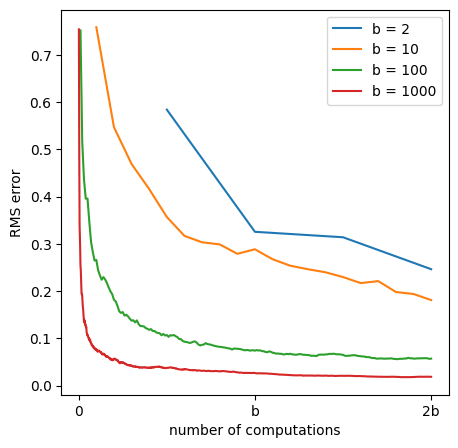

In [2]:
chapter08.figure_8_7(runs = 100,branch = [2, 10, 100, 1000])

---

注释（Notes）：

①  Shangtong Zhang 代码实现仓库，（<https://github.com/ShangtongZhang/reinforcement-learning-an-introduction>）。

参考文献（References）:

[1] Reinforcement learning (Wikipedia), <https://en.wikipedia.org/wiki/Reinforcement_learning>

[2] Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction (2nd edition). The MIT Press.（[加]Richard S. Sutton（理查德·桑顿）, [美]Andrew G. Barto（安德鲁·巴图） 著, 俞凯 等译.强化学习（第2版）.电子工业出版社, 2019.9）

[3] reinforcement-learning-an-introduction, <https://github.com/ShangtongZhang/reinforcement-learning-an-introduction>

[4] Multi-armed bandit, <https://en.wikipedia.org/wiki/Multi-armed_bandit#:~:text=In%20probability%20theory%20and%20machine,when%20each%20choice%27s%20properties%20are>